Based on a notebook by Stephen Taylor

This notebook uses a very basic population synthesis model to test out the analytical relations found in Lamb & Taylor 2024

In [1]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.constants import G, c
from astropy import units as u
from scipy.stats import rv_histogram, skew
from scipy.stats import kurtosis as kurt_sp
from matplotlib.lines import Line2D

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [3]:
cd /Users/lambwg/Documents/Vanderbilt/Research/pop_synth//

/Users/lambwg/Documents/Vanderbilt/Research/pop_synth


In [4]:
# Stephen Taylor's default matplotlib settings
rc_params = {"axes.labelsize": 10, "lines.markersize": 4, #"backend": "pdf", 
             "font.size": 10, "xtick.top": True, "ytick.right": True,
             "xtick.major.size": 6, "xtick.minor.size": 3,
             "ytick.major.size": 6, "ytick.minor.size": 3,
             "xtick.major.width": 0.5, "ytick.major.width": 0.5,
             "xtick.minor.width": 0.5, "ytick.minor.width": 0.5,
             "lines.markeredgewidth": 1, "axes.linewidth": 1.2,
             "legend.fontsize": 7, "xtick.labelsize": 10,
             "xtick.direction": "in", "xtick.minor.visible": True,
             "xtick.major.top": True, "xtick.minor.top": True,
             "ytick.labelsize": 10, "ytick.direction": "in",
             "ytick.minor.visible": True, "ytick.major.right": True,
             "ytick.minor.right": True, "savefig.dpi": 400,
             "path.simplify": True, "font.family": "serif",
             "font.serif": "Times", "text.usetex": True,
             "figure.figsize": [3.5503666805036667, 2.1942472810764047]}
plt.rcParams.update(rc_params)

In [37]:
# constants
fyr = 1 / 365.25 / 86400.0
G = 4.517103 * 10**-48  # Mpc3 / Msun s2
c = 9.7156119 * 10**-15  # Mpc / s

# Variation relations
This is a very basic population synthesis model that creates a distribution of binaries as a function of emitted GW frequency. For circular binaries that evolve purely due to GW emission, we expect that $\mathrm{d}t/\mathrm{d}f \propto f^{-11/3}$. Therefore, we sample from this distribution to get our binaries, bin them, and add them in quadrature

In [6]:
## Make a binary distribution function going as f^{-11/3}
A = 1e-22  # arbitrary normalisation
f = np.linspace(1e-9,1e-7,int(1e6))  # frequency grid
fbmid = 0.5 * (f[1:] + f[:-1])  # middle of grid cells
Nf = A * fbmid**(-11./3.)  # dt / df for GW emission

Text(0, 0.5, 'Number of sources')

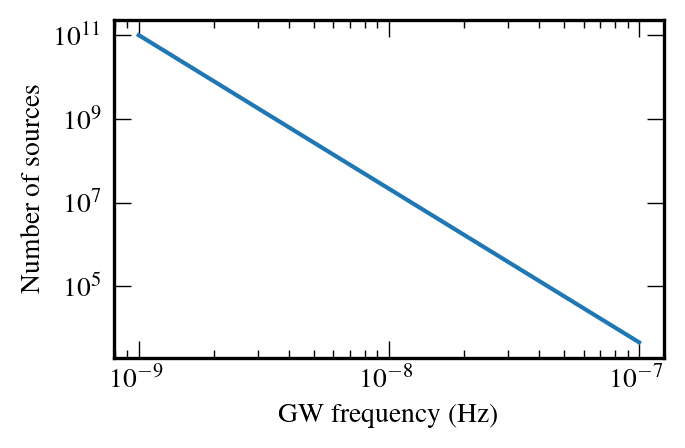

In [7]:
plt.loglog(fbmid, Nf)
plt.xlabel('GW frequency (Hz)')
plt.ylabel('Number of sources')

In [8]:
# we need to sample the binary distribution. Use scipy's rv_histogram
test = ss.rv_histogram((Nf,f)) # make a scipy.stats object

In [9]:
## Create structures for Omega_gw across realizations
Tspan = 20. * 86400 * 365.24
bins = (np.arange(1, 102) - 0.5) / Tspan  # 20-year bins
bmid = 0.5 * (bins[1:] + bins[:-1])  # bin mids

omega = np.zeros((bmid.shape[0], int(1e4))) # frequency-bins x realizations

In [10]:
# Make Omega_gw spectrum for each realization
for jj in range(omega.shape[1]):

    freqs = test.rvs(size=int(1e4))  # frequencies of 10000 sampled binaries
    mask = np.digitize(freqs, bins) - 1  # bin the binaries by frequency

    # Background spectrum is sum of squared strain amplitudes.
    # Power of 10/3 from h^2 and conversion from h_c^2(f) to Omega(f),
    # then binned by frequency
    for ii, bin in enumerate(bmid):
        omega[ii, jj] = np.sum(freqs[mask==ii]**(10/3) *
                               freqs[mask==ii]/Tspan)

The variance of the following quantities can be deduced analytically.

## $\Omega_\mathrm{GW}(f)$

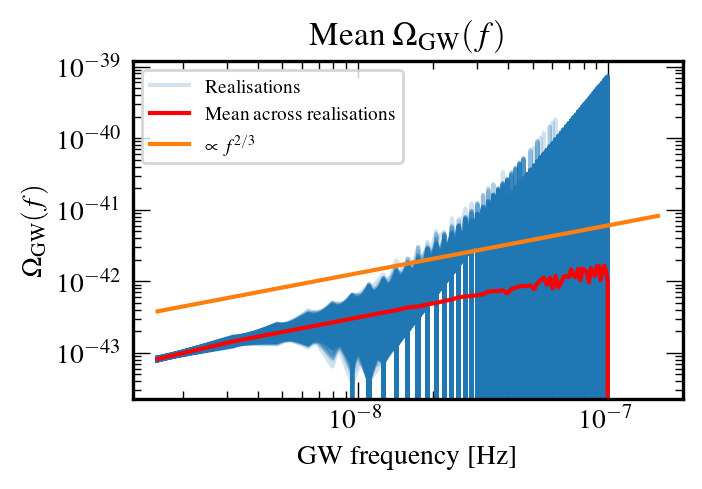

In [11]:
# Plot omega for all realizations
for jj in range(omega.shape[1]):
  plt.loglog(bmid, omega[:, jj], alpha=0.2, color='C0')
plt.loglog(bmid, np.mean(omega, axis=1), color='r')
plt.loglog(bmid, 2.8e-42 * (bmid/fyr)**(2/3), color='C1')

# legend handles and labels
h1 = Line2D([], [], alpha=0.2, color='C0', label='Realisations')
h2 = Line2D([], [], color='r', label='Mean across realisations')
h3 = Line2D([], [], color='C1', label=r'$\propto f^{2/3}$')
plt.legend(handles=[h1, h2, h3])

plt.xlabel('GW frequency [Hz]');
plt.ylabel(r'$\Omega_\mathrm{GW}(f)$');
plt.title(r'Mean $\Omega_\mathrm{GW}(f)$');

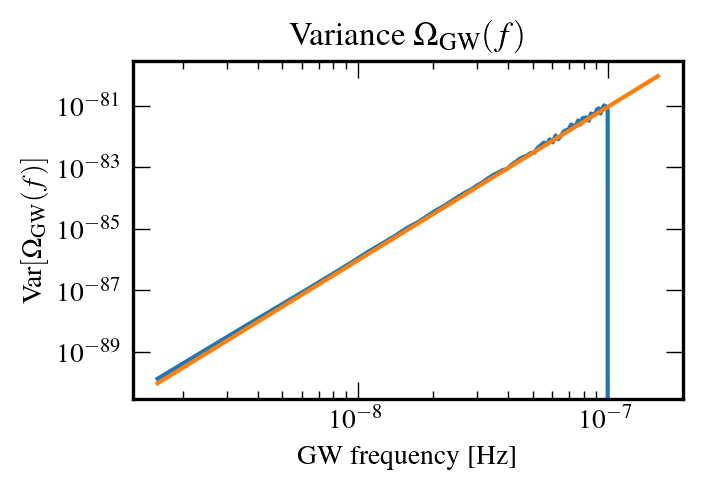

In [12]:
## Variance of Omega_gw
plt.loglog(bmid, np.var(omega, axis=1), label='Variance over realisations')
plt.loglog(bmid, 3e-84*(bmid/fyr)**(5.), label=r'$\propto f^5$')

plt.xlabel('GW frequency [Hz]');
plt.ylabel(r'Var$[\Omega_\mathrm{GW}(f)]$');
plt.title(r'Variance $\Omega_\mathrm{GW}(f)$');

## $h_\mathrm{c}^2(f)$

/Users/lambwg/Applications/miniconda3/envs/ceffyl/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/lambwg/Applications/miniconda3/envs/ceffyl/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/lambwg/Applications/miniconda3/envs/ceffyl/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


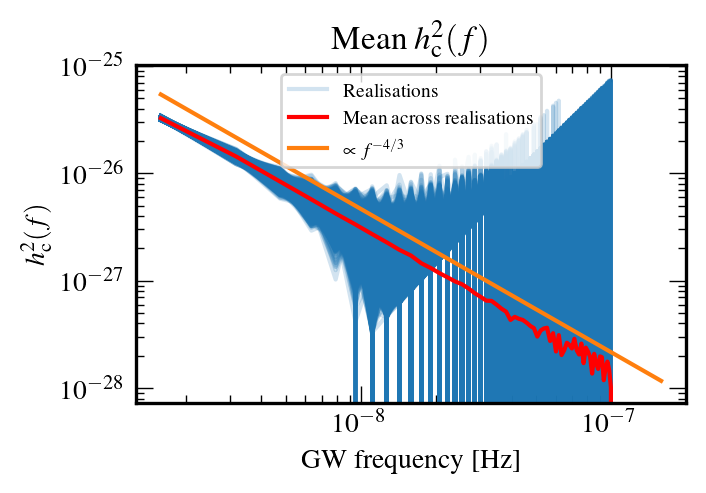

In [16]:
# Plot h_c^2(f) for all realizations
for jj in range(omega.shape[1]):
  plt.loglog(bmid, omega[:, jj]/bmid**2, alpha=0.2, color='C0')
plt.loglog(bmid, 1e-27 * (bmid/fyr)**(-4/3.), color='C1')
plt.loglog(bmid, np.mean(omega/bmid[:, None]**2, axis=1), color='r')

# legend handles and labels
h1 = Line2D([], [], alpha=0.2, color='C0', label='Realisations')
h2 = Line2D([], [], color='r', label='Mean across realisations')
h3 = Line2D([], [], color='C1', label=r'$\propto f^{-4/3}$')
plt.legend(handles=[h1, h2, h3])

plt.xlabel('GW frequency [Hz]');
plt.ylabel(r'$h_\mathrm{c}^2(f)$');
plt.title(r'Mean $h^2_\mathrm{c}(f)$');

Text(0.5, 1.0, 'Variance $h_\\mathrm{c}(f)^2$')

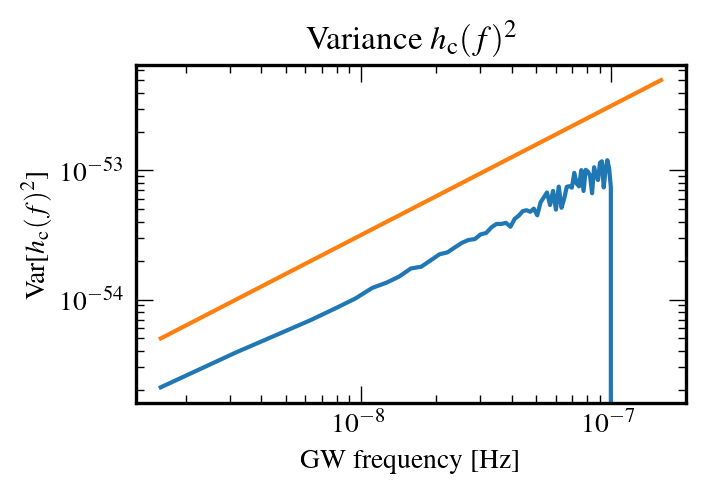

In [17]:
# variance of hc^2
plt.loglog(bmid, np.var(omega/bmid[:, None]**2, axis=1))
plt.loglog(bmid, 1.e-53*(bmid/fyr))
plt.xlabel('GW frequency [Hz]')
plt.ylabel(r'Var[$h_\mathrm{c}(f)^2$]')
plt.title(r'Variance $h_\mathrm{c}(f)^2$')

## $S_{\delta t}(f)$

Text(0.5, 1.0, 'Mean $S_{\\delta t}(f)$')

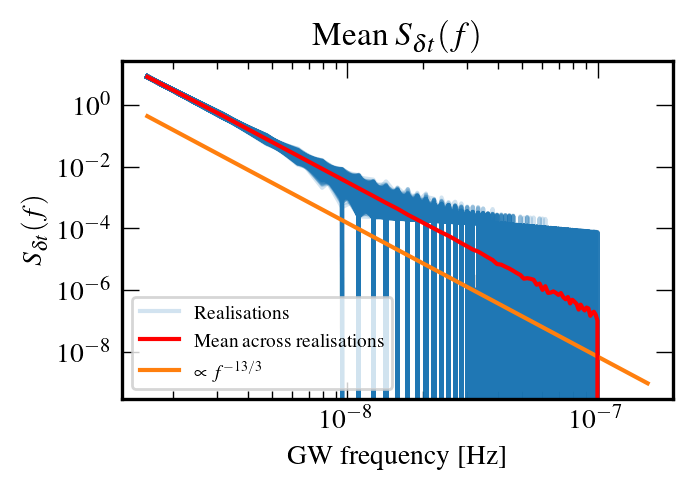

In [21]:
# Plot S(f) for all realizations
for jj in range(omega.shape[1]):
  plt.loglog(bmid, omega[:, jj]/bmid**5, alpha=0.2, color='C0')
plt.loglog(bmid, 1e-6 * (bmid/fyr)**(-13/3.), color='C1')
plt.loglog(bmid, np.mean(omega/bmid[:, None]**5, axis=1), color='r')

# legend handles and labels
h1 = Line2D([], [], alpha=0.2, color='C0', label='Realisations')
h2 = Line2D([], [], color='r', label='Mean across realisations')
h3 = Line2D([], [], color='C1', label=r'$\propto f^{-13/3}$')
plt.legend(handles=[h1, h2, h3], loc='lower left')

plt.xlabel('GW frequency [Hz]');
plt.ylabel(r'$S_{\delta t}(f)$');
plt.title(r'Mean $S_{\delta t}(f)$')

Text(0.5, 1.0, 'Variance $S_{\\delta t}(f)^2$')

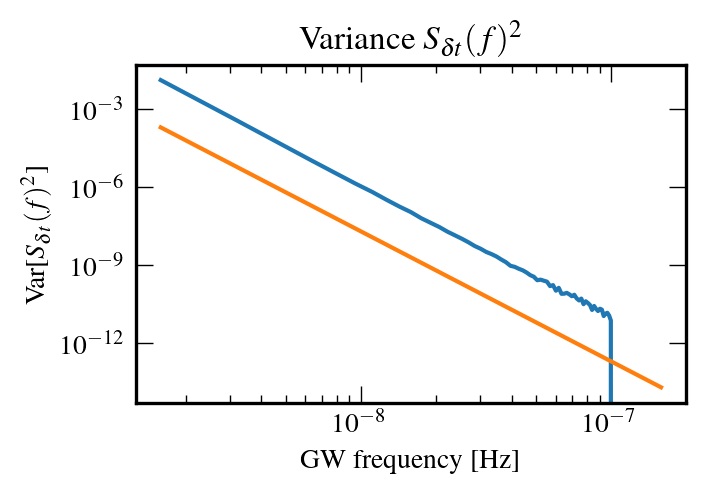

In [24]:
# variance of PSD
plt.loglog(bmid, np.var(omega/bmid[:, None]**5, axis=1))
plt.loglog(bmid, 2e-48*bmid**(-5.))
plt.xlabel('GW frequency [Hz]')
plt.ylabel(r'Var[$S_{\delta t}(f)^2$]')
plt.title(r'Variance $S_{\delta t}(f)^2$')

# General $dt/df$...

For binaries that also interact with their environments, their frequency evolution is faster, and $\lambda\neq-11/3$.

Let $\frac{dt}{df} \propto f^\lambda$

For stellar scattering, $\lambda = -7/3$

In [26]:
## Make a binary distribution function going as f^lambda
A = 1e-22  # arbitrary
f = np.linspace(1e-9, 1e-7, int(1e6))  # frequncy grid
fbmid = 0.5 * (f[1:] + f[:-1])  # middle of grid cells

lamb_da = -7/3  # stellar scattering
Nf = A * fbmid**lamb_da  # dt / df for GW emission

Text(0, 0.5, 'Number of sources')

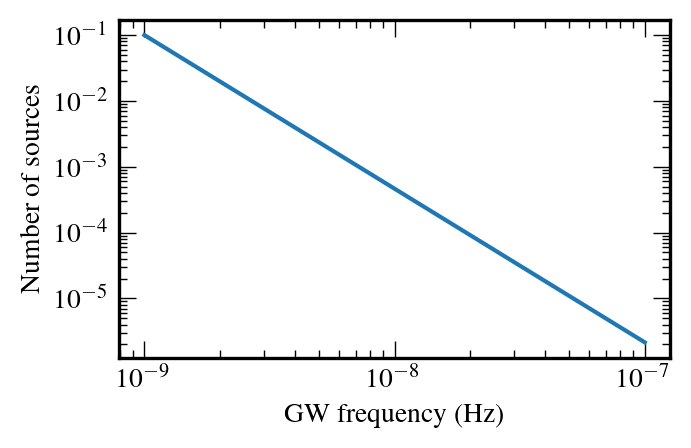

In [27]:
plt.loglog(fbmid, Nf)
plt.xlabel(r'GW frequency (Hz)')
plt.ylabel(r'Number of sources')

In [28]:
# we need to sample the binary distribution. Use scipy's rv_histogram
test = ss.rv_histogram((Nf,f)) # make a scipy.stats object

In [29]:
## Create structures for Omega_gw across realizations
Tspan = 20. * 86400 * 365.24
bins = (np.arange(1, 102) - 0.5) / Tspan  # 20-year bins
bmid = 0.5 * (bins[1:] + bins[:-1])  # bin mids

omega = np.zeros((bmid.shape[0], int(1e4))) # frequency-bins x realizations

In [30]:
# Make Omega_gw spectrum for each realization
for jj in range(omega.shape[1]):

    freqs = test.rvs(size=int(1e4))  # frequencies of 10000 sampled binaries
    mask = np.digitize(freqs, bins) - 1  # bin the binaries by frequency

    # Background spectrum is sum of squared strain amplitudes.
    # Power of 10/3 from h^2 and conversion from h_c^2(f) to Omega(f),
    # then binned by frequency
    for ii, bin in enumerate(bmid):
        omega[ii, jj] = np.sum(freqs[mask==ii]**(10/3) *
                               freqs[mask==ii]/Tspan)

## $\Omega_\mathrm{GW}(f)$

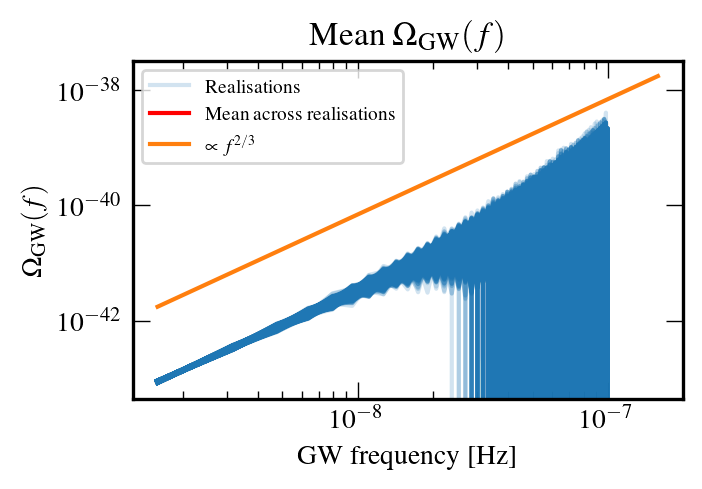

In [31]:
# Plot omega for all realizations
for jj in range(omega.shape[1]):
  plt.loglog(bmid, omega[:, jj], alpha=0.2, color='C0')
plt.loglog(bmid, 7e-40 * (bmid/fyr)**(lamb_da + 13/3), color='C1')

# legend handles and labels
h1 = Line2D([], [], alpha=0.2, color='C0', label='Realisations')
h2 = Line2D([], [], color='r', label='Mean across realisations')
h3 = Line2D([], [], color='C1', label=r'$\propto f^{2/3}$')
plt.legend(handles=[h1, h2, h3])

plt.xlabel('GW frequency [Hz]');
plt.ylabel(r'$\Omega_\mathrm{GW}(f)$');
plt.title(r'Mean $\Omega_\mathrm{GW}(f)$');

Text(0.5, 1.0, 'Variance $\\Omega_\\mathrm{GW}(f)$')

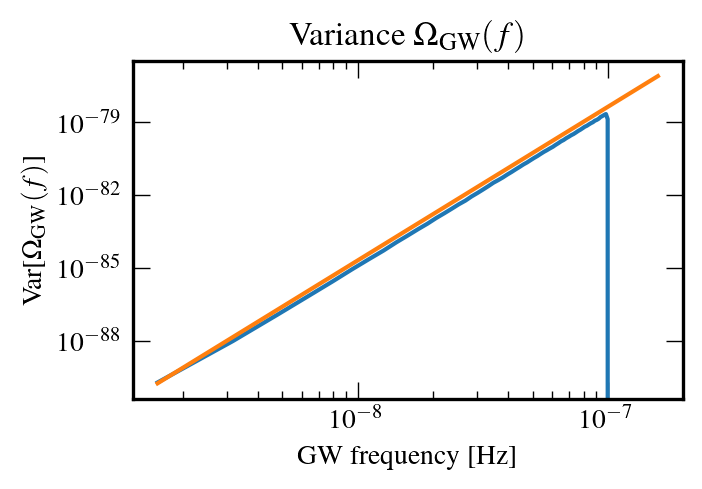

In [32]:
## Variance of Omega_gw
plt.loglog(bmid, np.var(omega, axis=1))
plt.loglog(bmid, 3e-82*(bmid/fyr)**(lamb_da + 26/3.))

plt.xlabel('GW frequency [Hz]')
plt.ylabel(r'Var[$\Omega_\mathrm{GW}(f)$]')
plt.title(r'Variance $\Omega_\mathrm{GW}(f)$')

## $h_\mathrm{c}^2(f)$

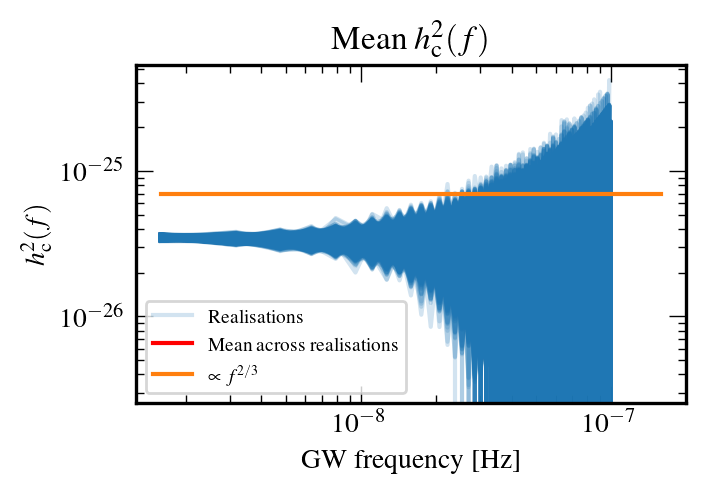

In [33]:
# Plot h_c^2 for all realizations
for jj in range(omega.shape[1]):
  plt.loglog(bmid, omega[:, jj]/bmid**2, alpha=0.2, color='C0')
plt.loglog(bmid, 7e-26 * (bmid/fyr)**(lamb_da + 7/3.), color='C1')

# legend handles and labels
h1 = Line2D([], [], alpha=0.2, color='C0', label='Realisations')
h2 = Line2D([], [], color='r', label='Mean across realisations')
h3 = Line2D([], [], color='C1', label=r'$\propto f^{2/3}$')
plt.legend(handles=[h1, h2, h3], loc='lower left')

plt.xlabel('GW frequency [Hz]');
plt.ylabel(r'$h_\mathrm{c}^2(f)$');
plt.title(r'Mean $h_\mathrm{c}^2(f)$');

Text(0.5, 1.0, 'Variance $h^2_\\mathrm{c}(f)$')

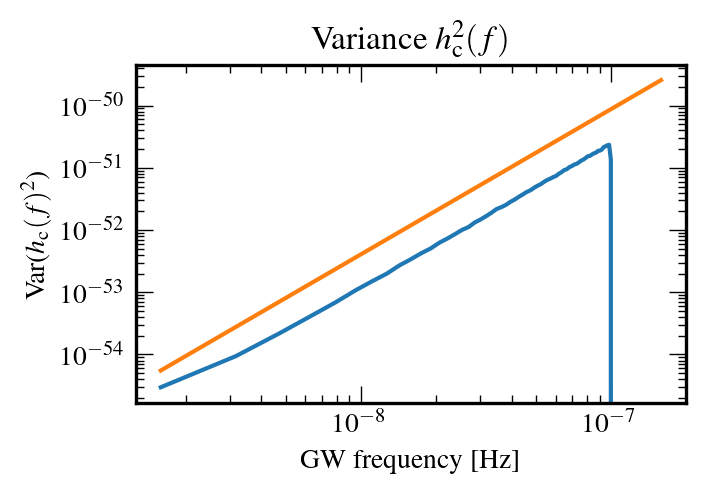

In [34]:
# variance of hc^2
plt.loglog(bmid, np.var(omega/bmid[:, None]**2, axis=1))
plt.loglog(bmid, 6.e-52*(bmid/fyr)**(lamb_da + 14/3))

plt.xlabel('GW frequency [Hz]')
plt.ylabel(r'Var($h_\mathrm{c}(f)^2$)')
plt.title(r'Variance $h^2_\mathrm{c}(f)$')

## $S_{\delta t}(f)$

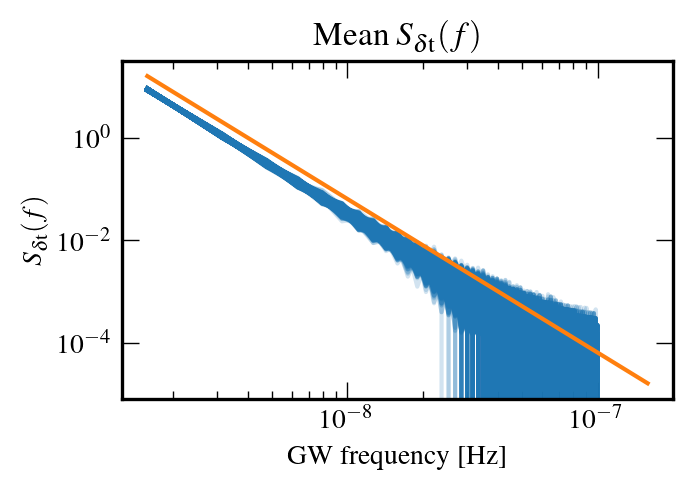

In [35]:
# Plot psd for all realizations
for jj in range(omega.shape[1]):
  plt.loglog(bmid, omega[:, jj]/bmid**5, alpha=0.2, color='C0')
plt.loglog(bmid, 2e-3 * (bmid/fyr)**(lamb_da-2/3.), color='C1')

plt.xlabel('GW frequency [Hz]');
plt.ylabel(r'$S_\mathrm{\delta t}(f)$')
plt.title(r'Mean $S_\mathrm{\delta t}(f)$');

Text(0.5, 1.0, 'Variance $S_\\mathrm{\\delta t}(f)$')

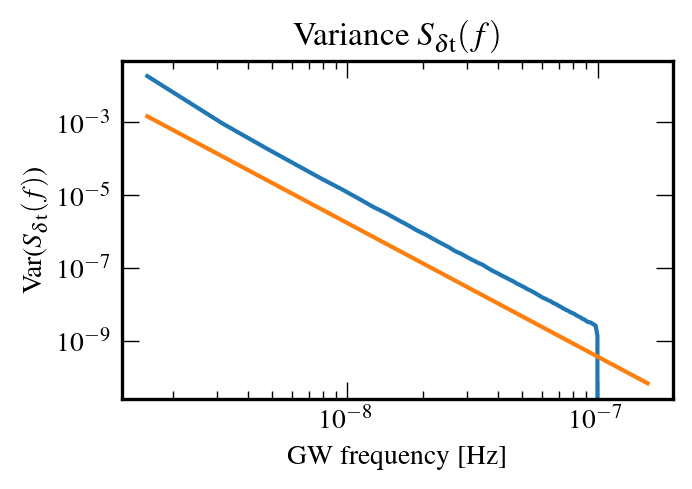

In [36]:
# variance of PSD
plt.loglog(bmid, np.var(omega/bmid[:, None]**5, axis=1))
plt.loglog(bmid, 2.5e-8*(bmid/fyr)**(lamb_da-4/3))

plt.xlabel('GW frequency [Hz]')
plt.ylabel(r'Var($S_\mathrm{\delta t}(f)$)')
plt.title(r'Variance $S_\mathrm{\delta t}(f)$')

These all work really well!!

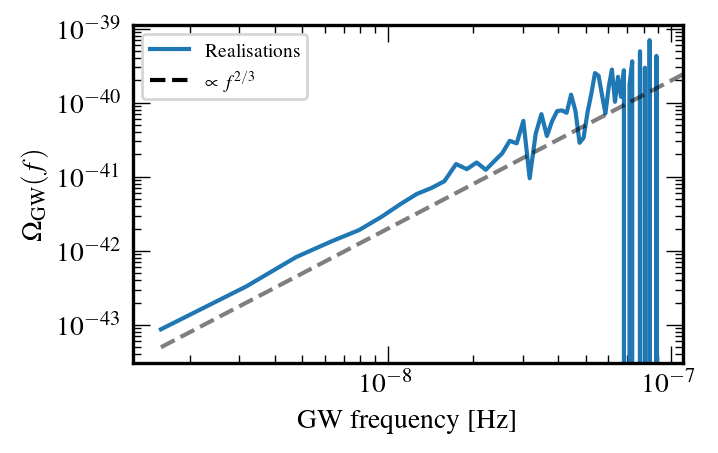

In [50]:
# Plot omega for all realizations
plt.loglog(bmid, omega[:, 100], alpha=1, color='C0')
plt.loglog(bmid, 2e-41 * (bmid/fyr)**(lamb_da + 13/3), color='k', ls='--', alpha=0.5)

# legend handles and labels
h1 = Line2D([], [], color='C0', label='Realisations')
#h2 = Line2D([], [], color='r', label='Mean across realisations')
h3 = Line2D([], [], color='k', ls='--', label=r'$\propto f^{2/3}$')
plt.legend(handles=[h1, h3])
plt.xlim(right=1.1e-7)

plt.xlabel('GW frequency [Hz]');
plt.ylabel(r'$\Omega_\mathrm{GW}(f)$');
#plt.title(r'Mean $\Omega_\mathrm{GW}(f)$');

# Synthesised idealised background

In [8]:
# define models
# MODEL 1
model1 = dict(alpha=1, log10_M_star=np.log10(3.2*10**7), beta=3, z0=3, n0_dot=2e-2)
model2 = dict(alpha=0.5, log10_M_star=np.log10(7.5*10**7), beta=2.5, z0=2.4, n0_dot=9.5e-3)
model3 = dict(alpha=0., log10_M_star=np.log10(1.8*10**8), beta=2, z0=1.8, n0_dot=1.5e-3)
model4 = dict(alpha=-0.5, log10_M_star=np.log10(4.2*10**8), beta=1.5, z0=1.1, n0_dot=9e-5)
model5 = dict(alpha=-1, log10_M_star=9., beta=1, z0=0.5, n0_dot=2e-6)
#model5 = dict(alpha=-1, log10_M_star=11., beta=1, z0=5, n0_dot=2.5e-11)

In [9]:
def dn_dlog10Mdz(log10_M, z, alpha, log10_M_star, beta, z0, n0_dot):
    """
        SMBHB number density per unit log10_M and unit redshift

        Parameters
        ----------
        z : float
            Redshift
        log10_M : float
            log10 of the chirp mass
        alpha : float
            Slope of the mass function
        log10_M_star : float
            Characteristic mass of the mass function
        beta : float
            Slope of the redshift function
        z0 : float
            Characteristic redshift of the redshift function
        n0_dot : float
            Normalization of the number density

        Returns
        -------
        float
            log10 SMBHB number density per unit log10_M and unit redshift
    """

    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

    # transform number density normalisation to the right units
    n0_dot *= u.Mpc**-3 * u.Gyr**-1
    n0_dot = n0_dot.to(1/(u.s * u.Mpc**3)).value

    log10M_dist = 10**-(alpha*(log10_M - 7.) +
                        10**(log10_M - log10_M_star) * np.log10(np.e))
    
    z_dist = (1+z)**beta * np.exp(-z/z0)

    # change in age of binary per unit redshift
    dt_dz = 1/((1+z) * cosmo.H(z).to('Mpc / Mpc s').value)

    return n0_dot * log10M_dist * z_dist * dt_dz



In [10]:
def gwb_ideal(f, log10_M, z, model_params):
    """
        Idealized GW characteristic strain squared

        Parameters
        ----------
        log10_M : float
            log10 of the chirp mass
        z : float
            Redshift
        model_params : dict
            Model parameters

        Returns
        -------
        log10_hc2 : float
            log10 of the idealized GW characteristic strain squared
    """
    log10_M_3d = log10_M[None, :, None]
    z_3d = z[None, None, :]

    dn = dn_dlog10Mdz(log10_M_3d, z_3d, **model_params)

    integrand = (1+z_3d)**(-1/3) * (10**log10_M_3d)**(5/3) * dn

    dlog10_M = log10_M[1] - log10_M[0]
    dz = z[1] - z[0]
    integral = ((integrand[:, 1:, 1:] + integrand[:, :-1, :-1]) * dlog10_M * dz / 4).sum(axis=(1,2))
    
    prefact = 4*G**(5/3) / (3 * np.pi**(1/3) * c**2 * f**(4/3))
    
    return prefact * integral

In [11]:
Tspan = 20 * 365.24 * 86400
f = np.arange(1, 31)/Tspan

#M = np.linspace(10**6, 10**11, 1000)
log10_M = np.linspace(6, 11, 1001)
z = np.linspace(0, 5, 101)

hc2_ideal = gwb_ideal(f, log10_M, z, model3)

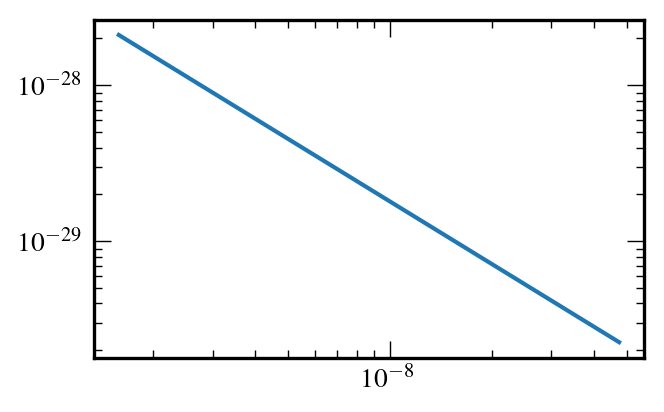

In [12]:
plt.plot(f, hc2_ideal)
plt.xscale('log', base=10)
plt.yscale('log', base=10)

# Poisson!

In [13]:
G = 4.517103 * 10**-48  # Mpc3 / Msun s2
c = 9.7156119 * 10**-15  # Mpc / s

In [14]:
def hc2_f(f, M, z):
    """
    """
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
    dL2 = cosmo.comoving_distance(z).to(u.Mpc).value ** -2.
    fr = f * (1+z)
    hc2 = 32/5 * c**-8. * (G * M)**(10/3) * dL2 * (np.pi*fr)**(4/3)

    return hc2

In [15]:
def dN_dlog10Mdzdlogf(f, M, z, model_params, return_int=True, mass_limit=True):
    """
    Assuming M and z are the edges of bins
    """
    f_3d = 0.5*(f[1:] + f[:-1])[:, None, None]
    M_3d = M[None, :, None]
    #log10_M_3d = np.log10(M)[None, :, None]
    z_3d = z[None, None, :]

    dlogf = (np.log(f[1:]) - np.log(f[:-1]))[:, None, None]
    #df = f[0]
    dlog10_M = (np.log10(M[1:]) - np.log10(M[:-1]))[None, :, None]
    dz = z[1] - z[0]

    #d2n = dn_dlog10Mdz(np.log10(M_3d), z_3d, **model_params) / (M_3d * np.log(10))
    d2n = dn_dlog10Mdz(np.log10(M_3d), z_3d, **model_params)

    fr = f_3d * (1+z_3d)
    dt_dlogfr = (5/96) * (G*M_3d/c**3)**(-5/3) * (np.pi * fr)**(-8/3)

    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
    dA2 = cosmo.comoving_distance(z_3d).to('Mpc').value ** 2.
    cosmofact = 4 * np.pi * c * (1+z_3d) * dA2

    dN_ = d2n * dt_dlogfr * cosmofact

    if mass_limit:
        dN_log10M = dN.sum(axis=2)
        cumtrapz = np.cumsum(dN_log10M[:, ::-1], axis=1)[:, ::-1]
        
        for ii in range(f.shape[0]-1):
            mask = cumtrapz[ii] < 1
            dN[ii, mask] = 0

    if return_int:
        dN = (dN_[:, 1:, 1:] + dN_[:, :-1, :-1]) * dlog10_M * dz / 4
        dN *= dlogf
    else:
        dN = dN_

    #return np.rint(dN).astype(int)
    return dN


In [16]:
Tspan = 20 * 365.24 * 86400
fbins = (np.arange(1, 32) - 0.5)/Tspan

In [17]:
z_bins = np.linspace(0, 5, 101)
#M_bins = np.linspace(10**6, 10**11, 1001)
log10_M_bins = np.linspace(6, 11, 1001)

#dM = M_bins[1] - M_bins[0]
#dz = z_bins[1] - z_bins[0]
#dlogf = np.log(fbins[1:]) - np.log(fbins[:-1])

f_mid = 0.5 * (fbins[1:] + fbins[:-1])
#M_mid = 0.5 * (M_bins[1:] + M_bins[:-1])
log10_M_mid = 0.5 * (log10_M_bins[1:] + log10_M_bins[:-1])
z_mid = 0.5 * (z_bins[1:] + z_bins[:-1])

In [18]:
N = dN_dlog10Mdzdlogf(fbins, 10**log10_M_bins, z_bins, model4, mass_limit=False)

In [19]:
N.shape

(30, 1000, 100)

In [20]:
N.sum()

1045194662.0414128

In [21]:
model1

{'alpha': 1,
 'log10_M_star': 7.505149978319906,
 'beta': 3,
 'z0': 3,
 'n0_dot': 0.02}

In [23]:
from tqdm import tqdm
nreal = 100000
dlogf = (np.log(fbins[1:]) - np.log(fbins[:-1]))
models = [model1, model2, model3, model4, model5]
h2cf = np.zeros((5, nreal, 30))

for ii in tqdm(range(5)):
    N = dN_dlog10Mdzdlogf(fbins, 10**log10_M_bins, z_bins, models[ii],
                          mass_limit=False)

    rng = np.random.default_rng()
    for nreal in range(nreal):
        s = rng.poisson(lam=N, size=(30, 1000, 100))
        h2 = hc2_f(f_mid[:, None, None],
                10**log10_M_mid[None, :, None],
                z_mid[None, None, :])
        h2cf[ii, nreal, :] = (s * h2).sum(axis=(-2,-1)) / dlogf

    np.save(f'./data/hc2f_10k_model{ii+1}', h2cf[ii])

100%|██████████| 5/5 [15:52:54<00:00, 11434.82s/it]  


In [37]:
#np.save('./data/hc2f_10k_model2', h2cf)
#np.save('./data/var_hc2f_10k_model4', var_h2cf)

#h2cf = np.load('./data/hc2f_10k_model2.npy')
#var_h2cf = np.load('./data/var_hc2f_10k.npy')

In [82]:
"""# bootstrap!
vars = np.zeros((100000, 30))
for ii in range(100000):
    idxs = np.random.choice(100000, 100000, replace=True)
    vars[ii] = np.var(h2cf[idxs], axis=0)"""

KeyboardInterrupt: 

Text(0.5, 0, 'GW Frequency (Hz)')

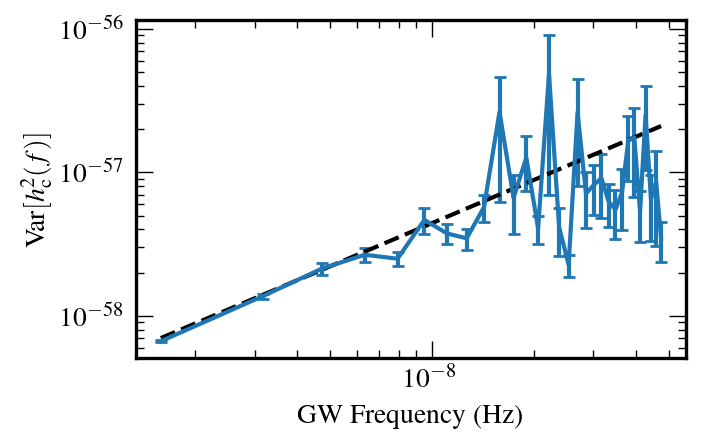

In [80]:
figsize_params = {"figure.figsize": [3.5503666805036667, 2.1942472810764047]}
plt.rcParams.update(figsize_params)

var = np.var(h2cf, axis=0)
plt.errorbar(f_mid, var, yerr=np.std(vars, axis=0), label='Realisations',
             capsize=2)
plt.plot(f_mid, 1.4e-57 * (f_mid/fyr)**(1), c='k', ls='--', label=r'$f^1$')
plt.xscale('log', base=10)
plt.yscale('log', base=10)
plt.ylabel(r'$\mathrm{Var}[h_\mathrm{c}^2(f)]$')
plt.xlabel(r'GW Frequency (Hz)')

Text(0.5, 0, 'GW Frequency (Hz)')

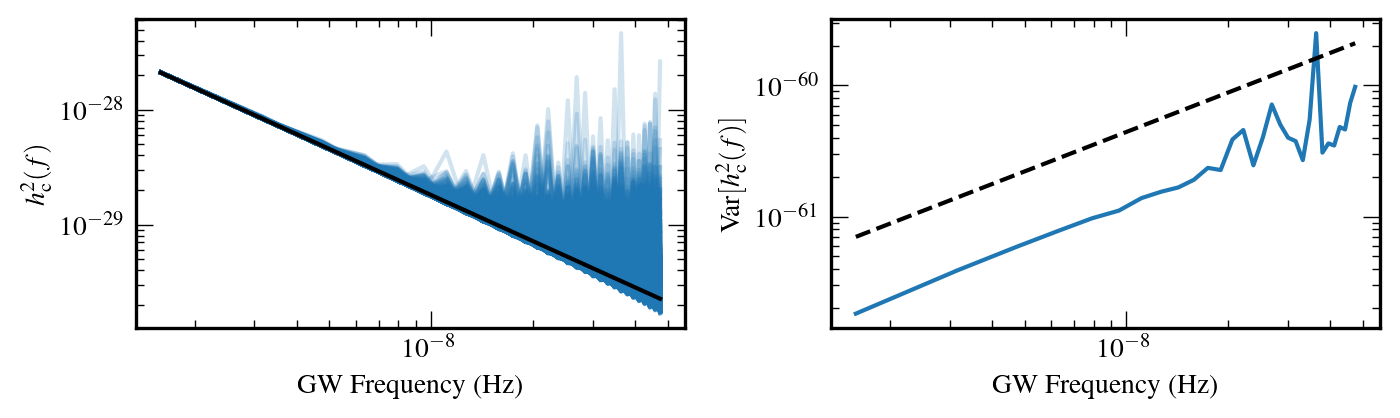

In [39]:
figsize_params = {"figure.figsize": [3.5503666805036667*2, 2.1942472810764047]}
plt.rcParams.update(figsize_params)

fig, axs = plt.subplots(ncols=2, tight_layout=True)
fyr = 1/(365.24*86400)

ax = axs[0]
ax.plot(f_mid, h2cf[0], c='C0', alpha=0.2, rasterized=True, label='GWB realisations')
[ax.plot(f_mid, h2cf[ii], c='C0', alpha=0.2, rasterized=True) for ii in range(1, nreal)]
#ax.plot(f_mid, np.mean(h2cf, axis=0), c='C1')
ax.plot(f_mid, hc2_ideal, c='k', rasterized=True, label='Phinney 2001')
#4ax.plot(f_mid, 5e-30*(f_mid/fyr)**(-4/3), c='r')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'$h_\mathrm{c}^2(f)$')
ax.set_xlabel(r'GW Frequency (Hz)')

ax = axs[1]
var = np.var(h2cf, axis=0)
#ax.errorbar(f_mid, var, yerr=np.std(vars, axis=0), label='Realisations',
#             capsize=2)
ax.plot(f_mid, var)
ax.plot(f_mid, 1.4e-60 * (f_mid/fyr)**(1), c='k', ls='--', label=r'$f^1$')
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
ax.set_ylabel(r'$\mathrm{Var}[h_\mathrm{c}^2(f)]$')
ax.set_xlabel(r'GW Frequency (Hz)')

#fig.savefig('./notebooks/figures/h2cf_10k.pdf', dpi=300);

In [23]:
nreal = h2cf.shape[0]

Text(0.5, 0, 'GW Frequency (Hz)')

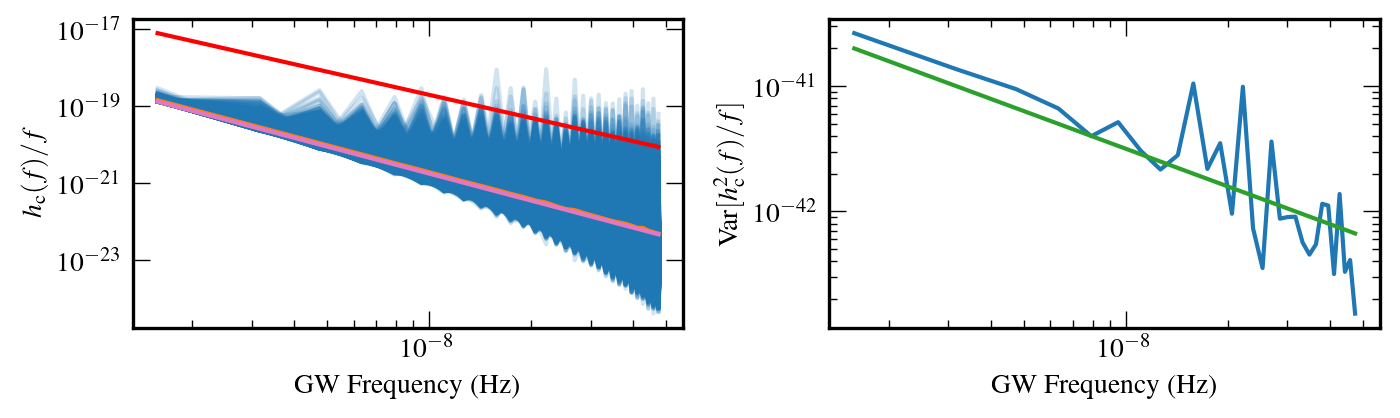

In [24]:
figsize_params = {"figure.figsize": [3.5503666805036667*2, 2.1942472810764047]}
plt.rcParams.update(figsize_params)

fig, axs = plt.subplots(ncols=2, tight_layout=True)
fyr = 1/(365.24*86400)

ax = axs[0]
ax.plot(f_mid, h2cf[0]/f_mid, c='C0', alpha=0.2, rasterized=True, label='GWB realisations')
[ax.plot(f_mid, h2cf[ii]/f_mid, c='C0', alpha=0.2, rasterized=True) for ii in range(1, nreal)]
ax.plot(f_mid, np.mean(h2cf/f_mid, axis=0), c='C1')
ax.plot(f_mid, hc2_ideal/f_mid, c='C6', rasterized=True, label='Phinney 2001')
ax.plot(f_mid, 2e-20*(f_mid/fyr)**-2, c='r')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'$h_\mathrm{c}(f)/f$')
ax.set_xlabel(r'GW Frequency (Hz)')

ax = axs[1]
var = np.var(h2cf/f_mid[None, :], axis=0)
plt.plot(f_mid, var, label='Realisations')
#[plt.plot(f_mid/fyr, var_h2cf[ii], c='C1', alpha=0.2) for ii in range(nreal)]
ax.plot(f_mid, 1e-42 * (f_mid/fyr)**-1, c='C2', label=r'$f^0$')
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
ax.set_ylabel(r'$\mathrm{Var}[h_\mathrm{c}^2(f)/f]$')
ax.set_xlabel(r'GW Frequency (Hz)')

#fig.savefig('./notebooks/figures/h2cf_10k.pdf', dpi=300);

Text(0.5, 0, 'GW Frequency (Hz)')

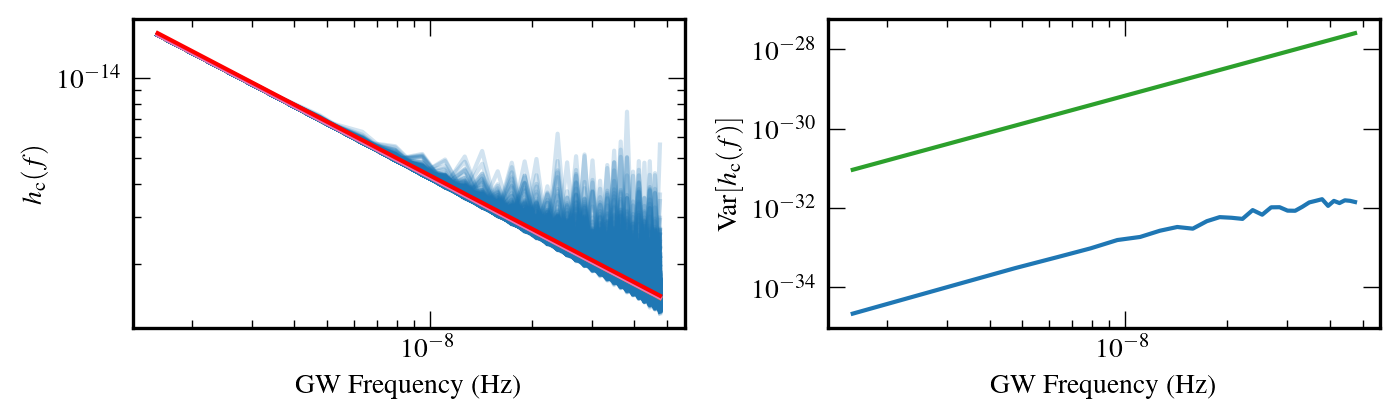

In [76]:
figsize_params = {"figure.figsize": [3.5503666805036667*2, 2.1942472810764047]}
plt.rcParams.update(figsize_params)

fig, axs = plt.subplots(ncols=2, tight_layout=True)
fyr = 1/(365.24*86400)

ax = axs[0]
ax.plot(f_mid, np.sqrt(h2cf[0]), c='C0', alpha=0.2, rasterized=True, label='GWB realisations')
[ax.plot(f_mid, np.sqrt(h2cf[ii]), c='C0', alpha=0.2, rasterized=True) for ii in range(1, nreal)]
ax.plot(f_mid, np.mean(np.sqrt(h2cf), axis=0), c='C1')
ax.plot(f_mid, np.sqrt(hc2_ideal), c='C6', rasterized=True, label='Phinney 2001')
ax.plot(f_mid, 2e-15*(f_mid/fyr)**(-2/3), c='r')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'$h_\mathrm{c}(f)$')
ax.set_xlabel(r'GW Frequency (Hz)')

ax = axs[1]
var = np.var(np.sqrt(h2cf), axis=0)
plt.plot(f_mid, var, label='Realisations')
#[plt.plot(f_mid/fyr, var_h2cf[ii], c='C1', alpha=0.2) for ii in range(nreal)]
ax.plot(f_mid, 1e-28 * (f_mid/fyr)**(7/3), c='C2', label=r'$f^0$')
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
ax.set_ylabel(r'$\mathrm{Var}[h_\mathrm{c}(f)]$')
ax.set_xlabel(r'GW Frequency (Hz)')

#fig.savefig('./notebooks/figures/h2cf_10k.pdf', dpi=300);

In [26]:
plt.close('all')

In [27]:
H0 = 70 * u.km/u.s/u.Mpc
H0 = H0.to(1/u.s).value

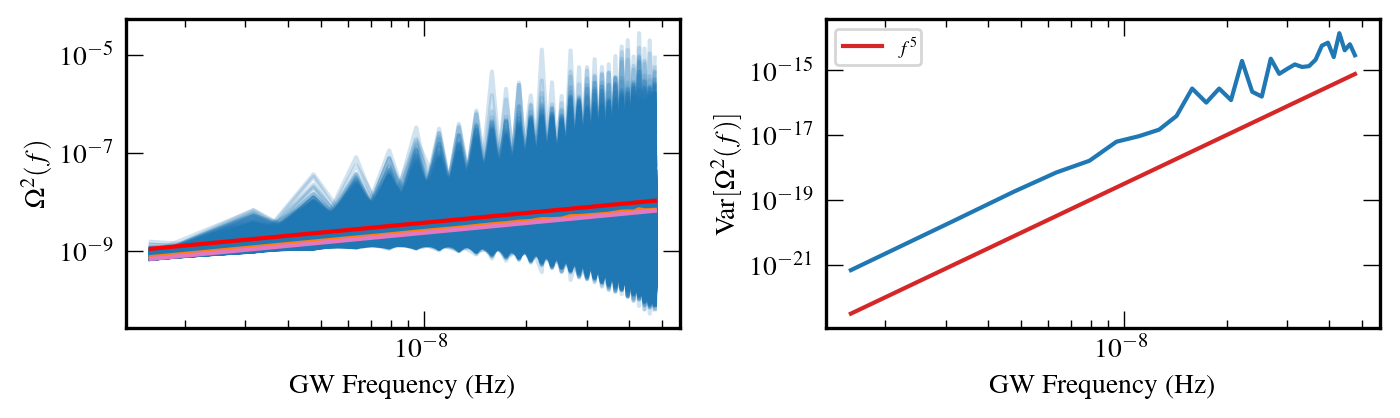

In [28]:
figsize_params = {"figure.figsize": [3.5503666805036667*2, 2.1942472810764047]}
plt.rcParams.update(figsize_params)

fig, axs = plt.subplots(ncols=2, tight_layout=True)
fyr = 1/(365.24*86400)

omega = (2*np.pi**2)/(3*H0**2) * f_mid[None, :]**2 * h2cf

ax = axs[0]
ax.plot(f_mid, omega[0], c='C0', alpha=0.2, rasterized=True, label='GWB realisations')
[ax.plot(f_mid, omega[ii], c='C0', alpha=0.2, rasterized=True) for ii in range(1, nreal)]
ax.plot(f_mid, np.mean(omega, axis=0), c='C1')
ax.plot(f_mid, (2*np.pi**2)/(3*H0**2) * f_mid**2 * hc2_ideal, c='C6', rasterized=True, label='Phinney 2001')
ax.plot(f_mid, 8e-9*(f_mid/fyr)**(2/3), c='r')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'$\Omega^2(f)$')
ax.set_xlabel(r'GW Frequency (Hz)')

ax = axs[1]
var = np.var(omega, axis=0)
plt.plot(f_mid, var)  #, label='Realisations')
#[plt.plot(f_mid/fyr, var_h2cf[ii], c='C1', alpha=0.2) for ii in range(nreal)]
#ax.plot(f_mid, 1e-15 * (f_mid/fyr)**(12/3), c='C2', label=r'$f^4$')
ax.plot(f_mid, 1e-16 * (f_mid/fyr)**(15/3), c='C3', label=r'$f^5$')
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
ax.set_ylabel(r'$\mathrm{Var}[\Omega^2(f)]$')
ax.set_xlabel(r'GW Frequency (Hz)')
ax.legend()

#fig.savefig('./notebooks/figures/h2cf_10k.pdf', dpi=300);

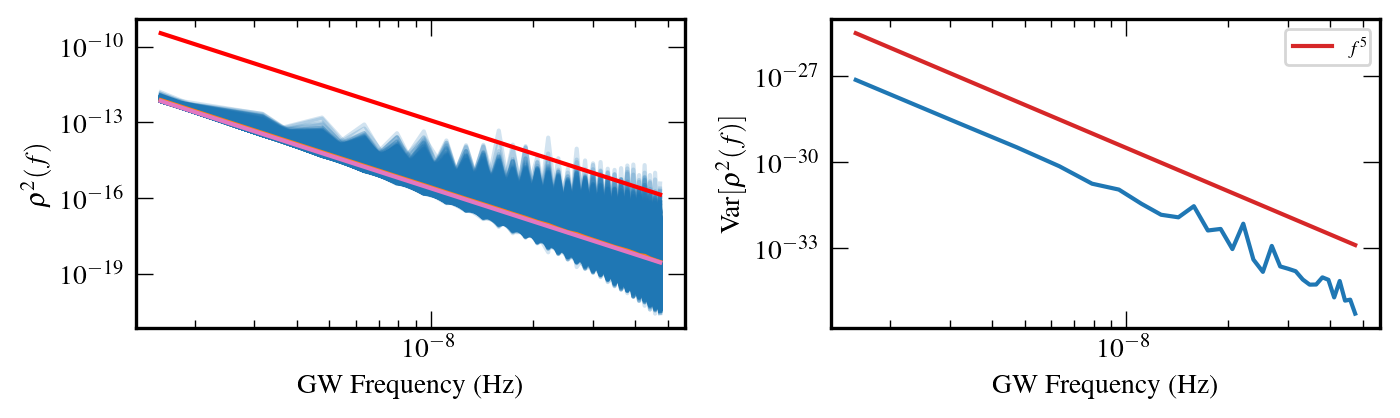

In [29]:
figsize_params = {"figure.figsize": [3.5503666805036667*2, 2.1942472810764047]}
plt.rcParams.update(figsize_params)

fig, axs = plt.subplots(ncols=2, tight_layout=True)
fyr = 1/(365.24*86400)

rho2 = h2cf / (12 * np.pi**2 * f_mid[None, :]**3 * Tspan)

ax = axs[0]
ax.plot(f_mid, rho2[0], c='C0', alpha=0.2, rasterized=True, label='GWB realisations')
[ax.plot(f_mid, rho2[ii], c='C0', alpha=0.2, rasterized=True) for ii in range(1, nreal)]
ax.plot(f_mid, np.mean(rho2, axis=0), c='C1')
ax.plot(f_mid, hc2_ideal / (12 * np.pi**2 * f_mid**3 * Tspan), c='C6', rasterized=True, label='Phinney 2001')
ax.plot(f_mid, 8e-16*(f_mid/fyr)**(-13/3), c='r')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'$\rho^2(f)$')
ax.set_xlabel(r'GW Frequency (Hz)')

ax = axs[1]
var = np.var(rho2, axis=0)
plt.plot(f_mid, var)  #, label='Realisations')
#[plt.plot(f_mid/fyr, var_h2cf[ii], c='C1', alpha=0.2) for ii in range(nreal)]
#ax.plot(f_mid, 1e-15 * (f_mid/fyr)**(12/3), c='C2', label=r'$f^4$')
ax.plot(f_mid, 1e-32 * (f_mid/fyr)**(-15/3), c='C3', label=r'$f^5$')
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
ax.set_ylabel(r'$\mathrm{Var}[\rho^2(f)]$')
ax.set_xlabel(r'GW Frequency (Hz)')
ax.legend()

#fig.savefig('./notebooks/figures/h2cf_10k.pdf', dpi=300);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


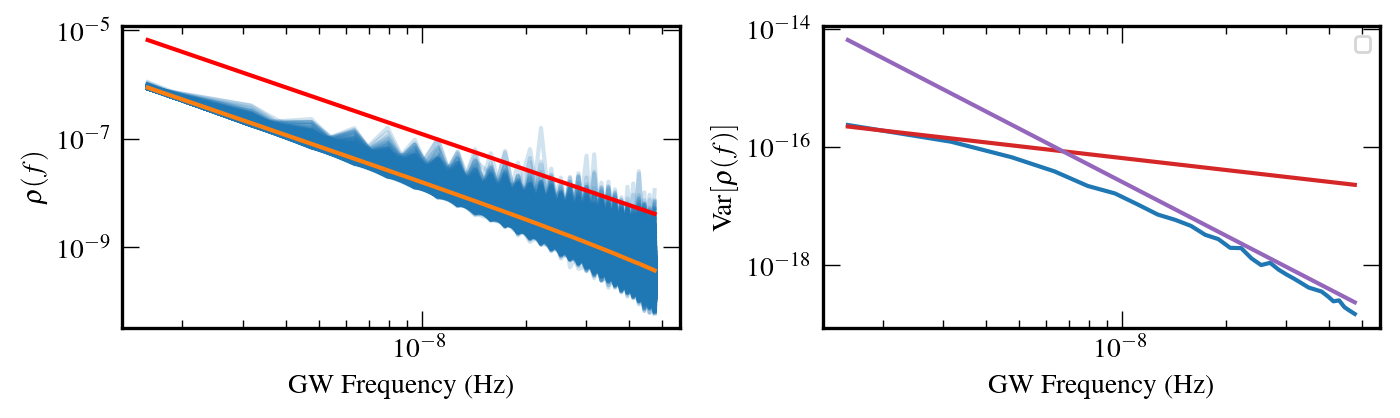

In [30]:
figsize_params = {"figure.figsize": [3.5503666805036667*2, 2.1942472810764047]}
plt.rcParams.update(figsize_params)

nreal = 10000 #h2cf.shape[0]
fig, axs = plt.subplots(ncols=2, tight_layout=True)
fyr = 1/(365.24*86400)

rho2 = h2cf / (12 * np.pi**2 * f_mid[None, :]**3 * Tspan)
rho = np.sqrt(rho2)

ax = axs[0]
ax.plot(f_mid, rho[0], c='C0', alpha=0.2, rasterized=True, label='GWB realisations')
[ax.plot(f_mid, rho[ii], c='C0', alpha=0.2, rasterized=True) for ii in range(1, nreal)]
ax.plot(f_mid, np.mean(rho, axis=0), c='C1')
#ax.plot(f_mid, np.sqrt(hc2_ideal / (12 * np.pi**2 * f_mid**3 * Tspan)), c='C6', rasterized=True, label='Phinney 2001')
ax.plot(f_mid, 1e-8 * (f_mid/fyr)**-(13/6), c='r')
ax.set_ylabel(r'$\rho(f)$')
ax.set_xlabel(r'GW Frequency (Hz)')
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)

ax = axs[1]
var = np.var(rho, axis=0)
plt.plot(f_mid, var)  #, label='Realisations')
#[plt.plot(f_mid/fyr, var_h2cf[ii], c='C1', alpha=0.2) for ii in range(nreal)]
#ax.plot(f_mid, 1e-15 * (f_mid/fyr)**(12/3), c='C2', label=r'$f^4$')
#ax.plot(f_mid, 1e-3 * (f_mid/fyr)**(11/3), c='C3')
ax.plot(f_mid, 3e-17 * (f_mid/fyr)**(-2/3), c='C3')
ax.plot(f_mid, 8e-19 * (f_mid/fyr)**(-3), c='C4')
fyr = 1/(365.24*86400)
#plt.plot(f_mid, var_hc2f/(4*np.log(10)*hc2f**2), c='C1')
ax.set_ylabel(r'$\mathrm{Var}[\rho(f)]$')
ax.set_xlabel(r'GW Frequency (Hz)')
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
ax.legend()

#fig.savefig('./notebooks/figures/h2cf_10k.pdf', dpi=300);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


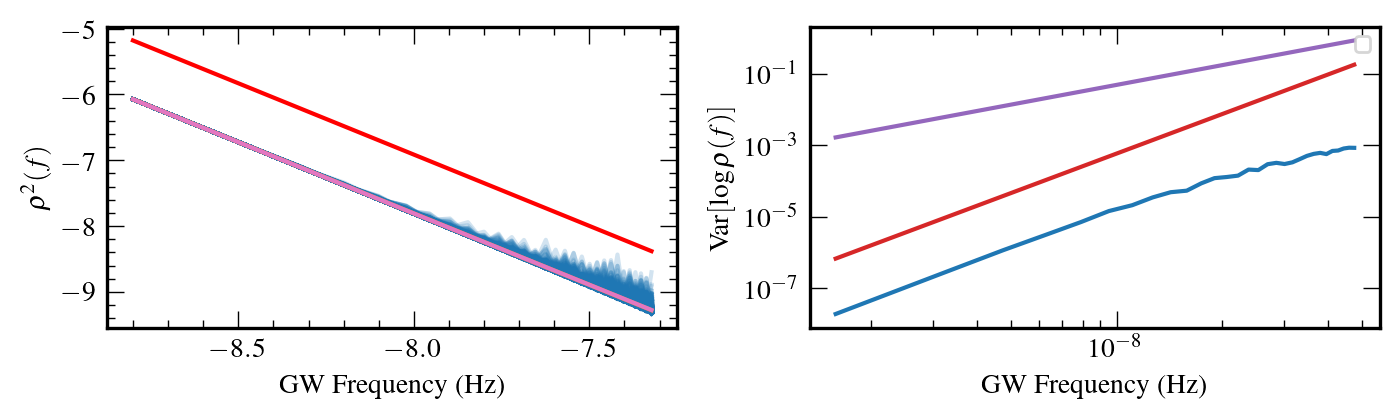

In [77]:
figsize_params = {"figure.figsize": [3.5503666805036667*2, 2.1942472810764047]}
plt.rcParams.update(figsize_params)

nreal = 10000 #h2cf.shape[0]
fig, axs = plt.subplots(ncols=2, tight_layout=True)
fyr = 1/(365.24*86400)

rho2 = h2cf / (12 * np.pi**2 * f_mid[None, :]**3 * Tspan)
log10_rho = 0.5 * np.log10(rho2)

ax = axs[0]
ax.plot(np.log10(f_mid), log10_rho[0], c='C0', alpha=0.2, rasterized=True, label='GWB realisations')
[ax.plot(np.log10(f_mid), log10_rho[ii], c='C0', alpha=0.2, rasterized=True) for ii in range(1, nreal)]
ax.plot(np.log10(f_mid), np.mean(log10_rho, axis=0), c='C1')
ax.plot(np.log10(f_mid), 0.5*np.log10(hc2_ideal / (12 * np.pi**2 * f_mid**3 * Tspan)), c='C6', rasterized=True, label='Phinney 2001')
ax.plot(np.log10(f_mid), -8 - (13/6)*np.log10(f_mid/fyr), c='r')
#ax.plot(np.log10(f_mid), -8 - (5/6)*np.log10(f_mid/fyr), c='r')
ax.set_ylabel(r'$\rho^2(f)$')
ax.set_xlabel(r'GW Frequency (Hz)')

ax = axs[1]
var = np.var(log10_rho, axis=0)
plt.plot(f_mid, var)  #, label='Realisations')
#[plt.plot(f_mid/fyr, var_h2cf[ii], c='C1', alpha=0.2) for ii in range(nreal)]
#ax.plot(f_mid, 1e-15 * (f_mid/fyr)**(12/3), c='C2', label=r'$f^4$')
ax.plot(f_mid, 4e-2 * (f_mid/fyr)**(11/3), c='C3')
ax.plot(f_mid, 4e-1 * (f_mid/fyr)**(11/6), c='C4')
fyr = 1/(365.24*86400)
#plt.plot(f_mid, var_hc2f/(4*np.log(10)*hc2f**2), c='C1')
ax.set_ylabel(r'$\mathrm{Var}[\log\rho(f)]$')
ax.set_xlabel(r'GW Frequency (Hz)')
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
ax.legend()

#fig.savefig('./notebooks/figures/h2cf_10k.pdf', dpi=300);

In [32]:
log10_rho.shape
vars_l10r = np.zeros_like(log10_rho)
for ii in range(log10_rho.shape[0]):
    idxs = np.random.choice(log10_rho.shape[0], log10_rho.shape[0], replace=True)
    vars_l10r[ii, :] = np.var(log10_rho[idxs, :], axis=0)

KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


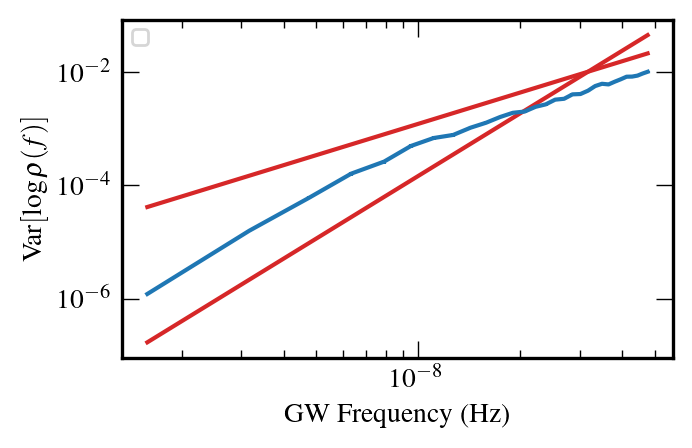

In [ ]:
figsize_params = {"figure.figsize": [3.5503666805036667, 2.1942472810764047]}
plt.rcParams.update(figsize_params)

var = np.var(log10_rho, axis=0)
plt.errorbar(f_mid, var, yerr=np.std(vars_l10r, axis=0))  #, label='Realisations')
#[plt.plot(f_mid/fyr, var_h2cf[ii], c='C1', alpha=0.2) for ii in range(nreal)]
#ax.plot(f_mid, 1e-15 * (f_mid/fyr)**(12/3), c='C2', label=r'$f^4$')
plt.plot(f_mid, 1e-2 * (f_mid/fyr)**(11/3), c='C3')
plt.plot(f_mid, 1e-2 * (f_mid/fyr)**(11/6), c='C3')
fyr = 1/(365.24*86400)
#plt.plot(f_mid, var_hc2f/(4*np.log(10)*hc2f**2), c='C1')
plt.ylabel(r'$\mathrm{Var}[\log\rho(f)]$')
plt.xlabel(r'GW Frequency (Hz)')
plt.xscale('log', base=10)
plt.yscale('log', base=10)
plt.legend()

## checking distributions per frequency

In [35]:
h2cf.shape

(100000, 30)

Text(0.5, 0, '$h_\\mathrm{c}^2(f)$')

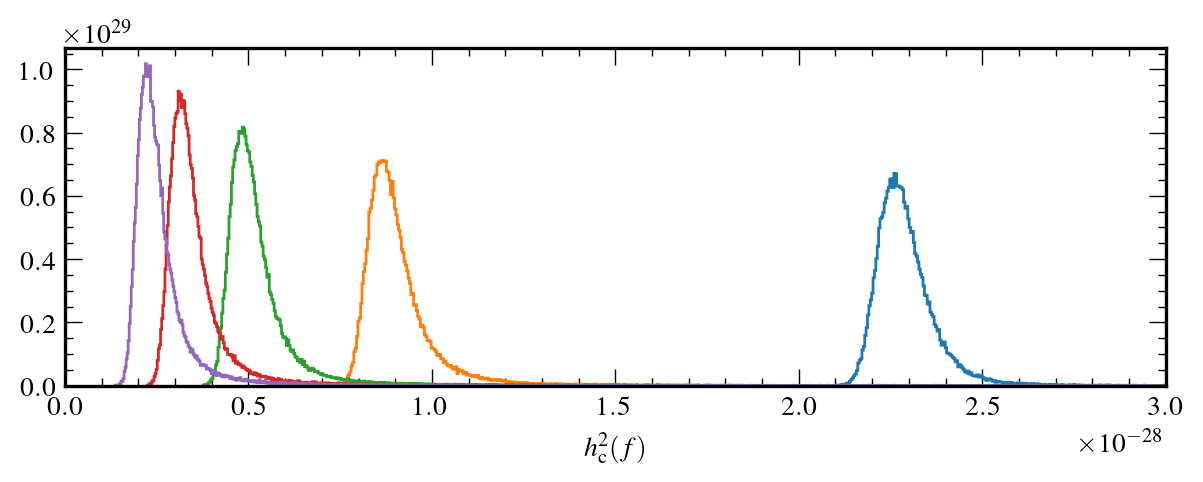

In [41]:
for ii in range(5):
    plt.hist(h2cf[:, ii], density=True, histtype='step', bins='fd');
plt.xlim(0, 3e-28)
plt.xlabel(r'$h_\mathrm{c}^2(f)$')

python(21303) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21319) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21335) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21347) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21356) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21372) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21388) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21389) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21405) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


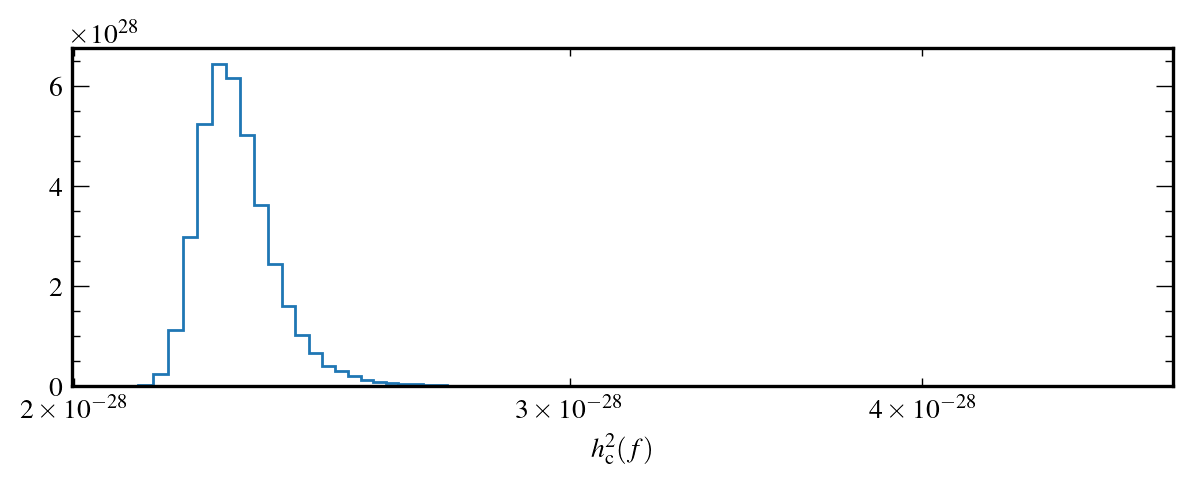

In [70]:
for ii in range(1):
    plt.hist(h2cf[:, ii], density=True, histtype='step', bins=100);
#plt.xlim(0, 3e-28)
plt.xlabel(r'$h_\mathrm{c}^2(f)$')
plt.xscale('log', base=10)

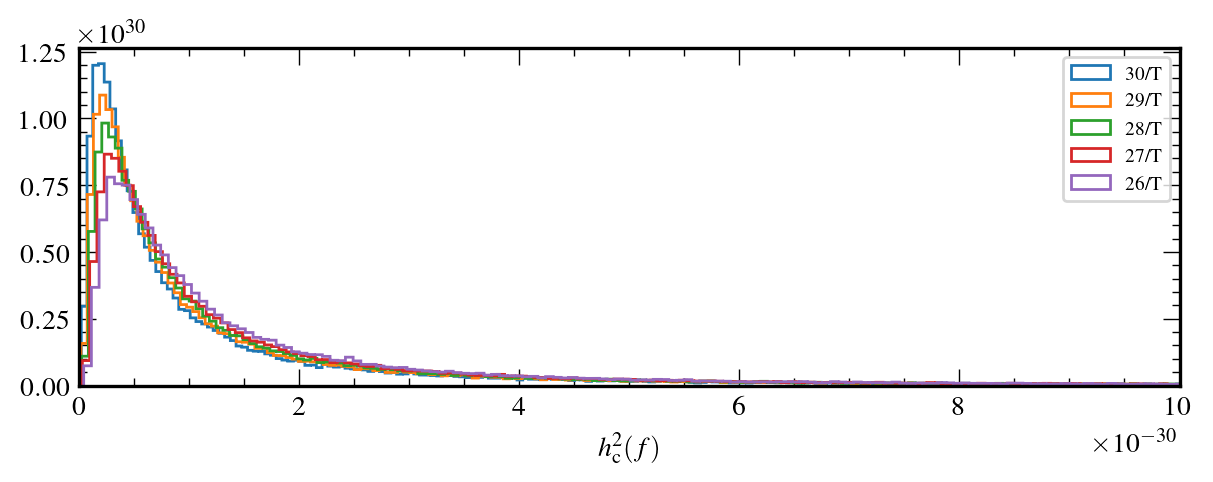

In [61]:
for ii in range(1, 6):
    plt.hist(h2cf[:, -ii], density=True, histtype='step', bins='fd',
             label=f'{31-ii}/T');
plt.xlim(0, 1e-29)
plt.xlabel(r'$h_\mathrm{c}^2(f)$')
plt.legend();

Text(0.5, 0, '$h_\\mathrm{c}(f)$')

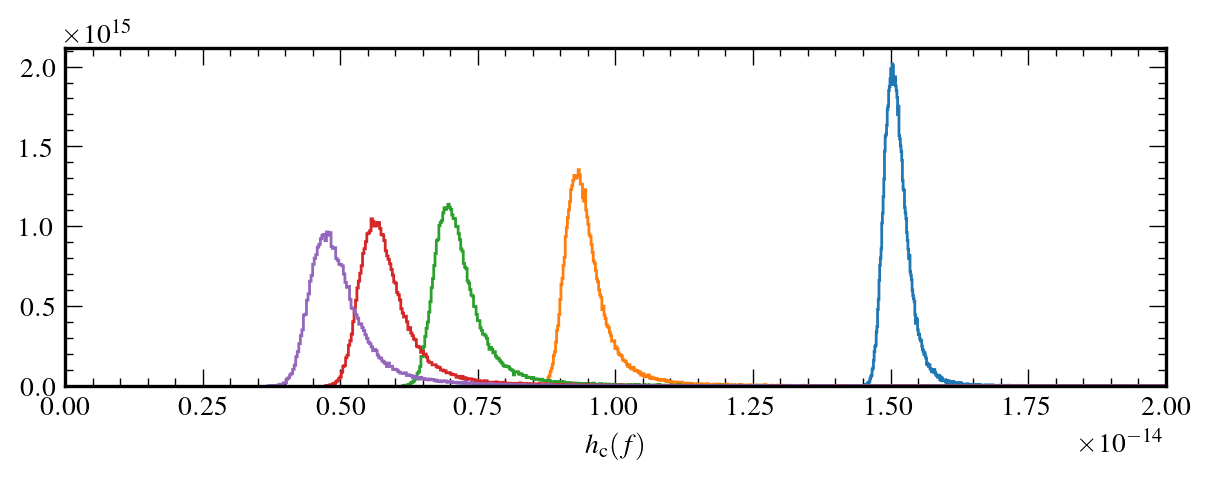

In [43]:
for ii in range(5):
    plt.hist(np.sqrt(h2cf[:, ii]), density=True, histtype='step', bins='fd');
plt.xlim(0, 2e-14)
plt.xlabel(r'$h_\mathrm{c}(f)$')

Text(0.5, 0, '$h_\\mathrm{c}(f)$')

python(92063) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(92071) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(92081) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(92096) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(92099) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(92131) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(92150) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(92167) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(92171) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(92188) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(92224) Malloc

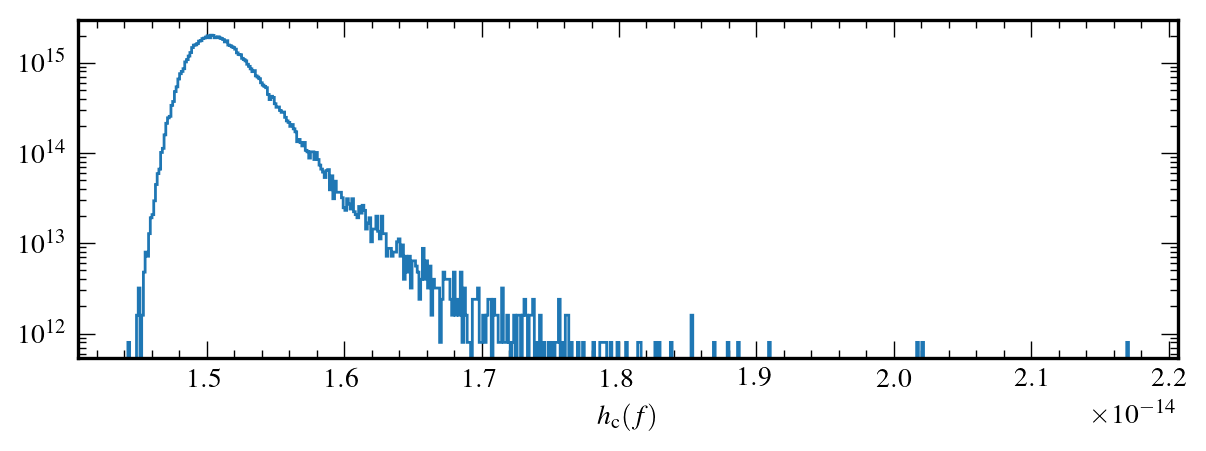

In [67]:
for ii in range(1):
    plt.hist(np.sqrt(h2cf[:, ii]), density=True, histtype='step', bins='fd');
#plt.xlim(0, 2e-14)
plt.xlabel(r'$h_\mathrm{c}(f)$')
plt.xscale('log', base=10)

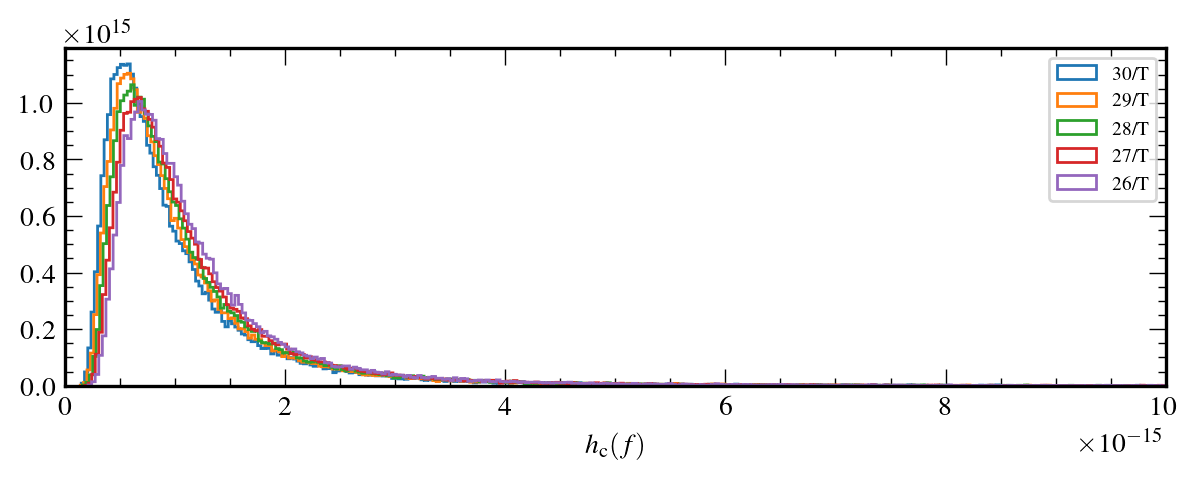

In [59]:
for ii in range(1, 6):
    plt.hist(np.sqrt(h2cf[:, -ii]), density=True, histtype='step', bins='fd',
             label=f'{31-ii}/T');
plt.xlim(0, 1e-14)
plt.xlabel(r'$h_\mathrm{c}(f)$')
plt.legend();

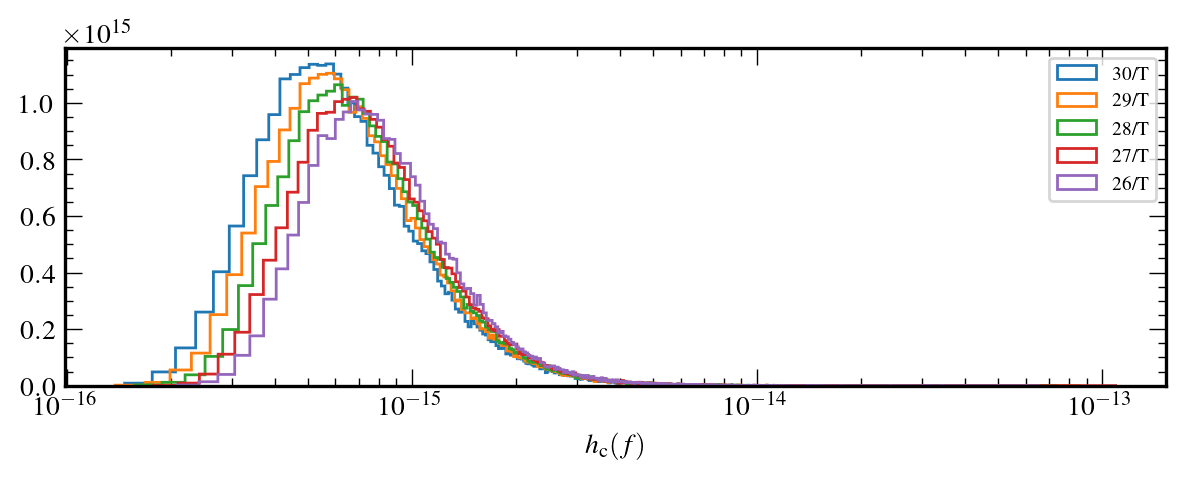

In [65]:
for ii in range(1, 6):
    plt.hist(np.sqrt(h2cf[:, -ii]), density=True, histtype='step', bins='fd',
             label=f'{31-ii}/T');
#plt.xlim(0, 1e-14)
plt.xlabel(r'$h_\mathrm{c}(f)$')
plt.legend();
plt.xscale('log', base=10)

Text(0.5, 0, '$\\propto \\Omega_{GW}(f)$')

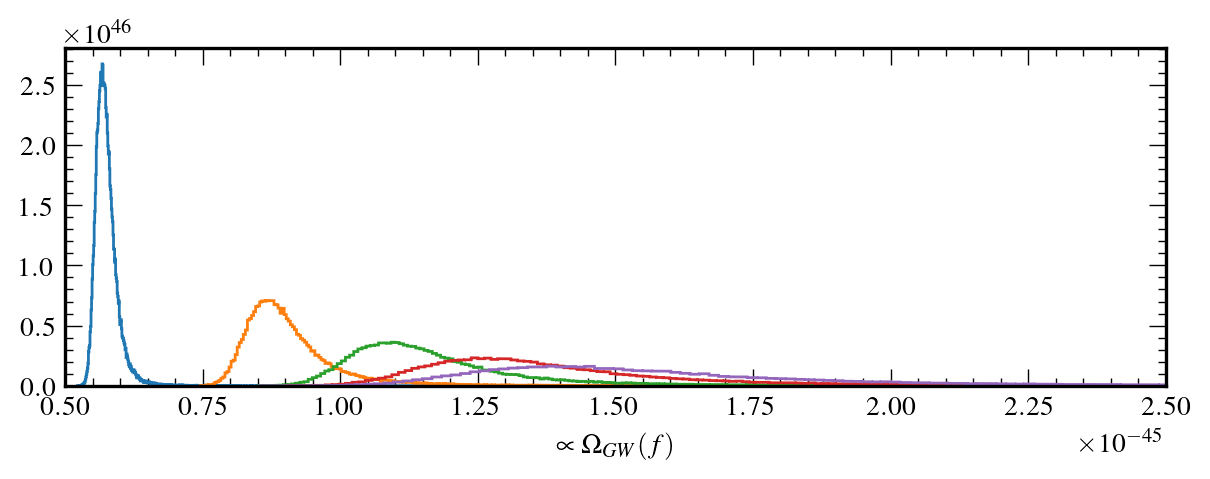

In [48]:
for ii in range(5):
    plt.hist(f_mid[ii]**2 * h2cf[:, ii], density=True, histtype='step', bins='fd');
plt.xlim(0.5e-45, 2.5e-45)
plt.xlabel(r'$\propto \Omega_{GW}(f)$')

Text(0.5, 0, '$\\propto S_h(f)$')

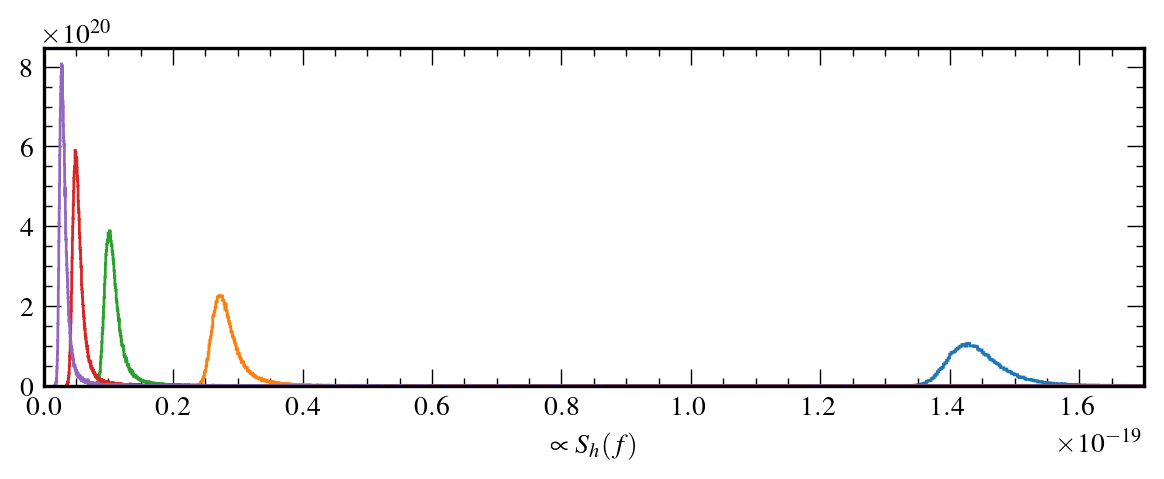

In [50]:
for ii in range(5):
    plt.hist(h2cf[:, ii]/f_mid[ii], density=True, histtype='step', bins='fd');
plt.xlim(0.5e-45, 1.7e-19)
plt.xlabel(r'$\propto S_h(f)$')#

Text(0.5, 0, '$\\propto \\rho^2(f)$')

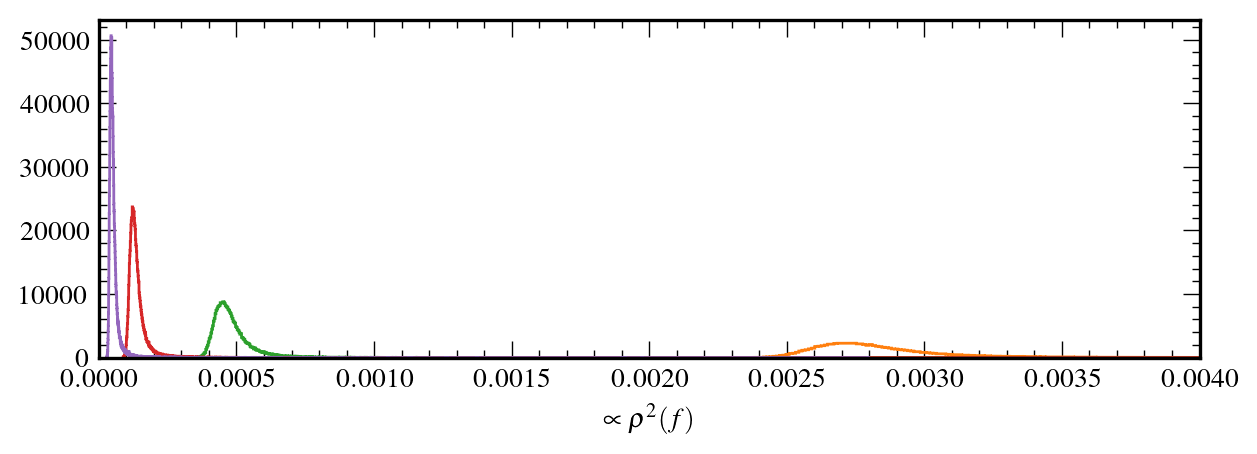

In [54]:
for ii in range(5):
    plt.hist(h2cf[:, ii]/f_mid[ii]**3, density=True, histtype='step', bins='fd');
plt.xlim(0., 0.004)
plt.xlabel(r'$\propto \rho^2(f)$')#

Text(0.5, 0, '$1/2 \\log_{10}\\hat{\\rho}(f)$')

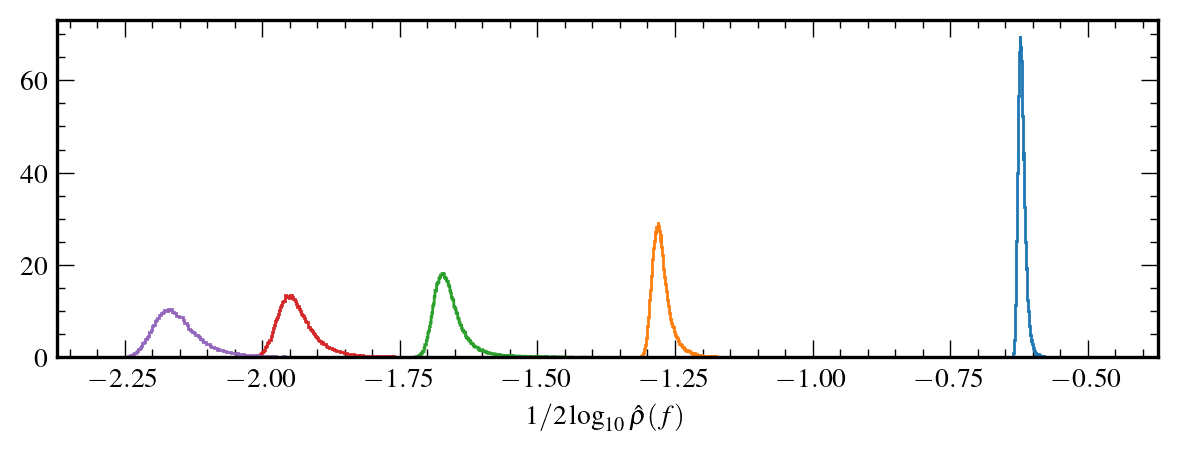

In [55]:
for ii in range(5):
    plt.hist(0.5*np.log10(h2cf[:, ii]/f_mid[ii]**3), density=True, histtype='step', bins='fd');
#plt.xlim(0., 0.004)
plt.xlabel(r'$1/2 \log_{10}\hat{\rho}(f)$')

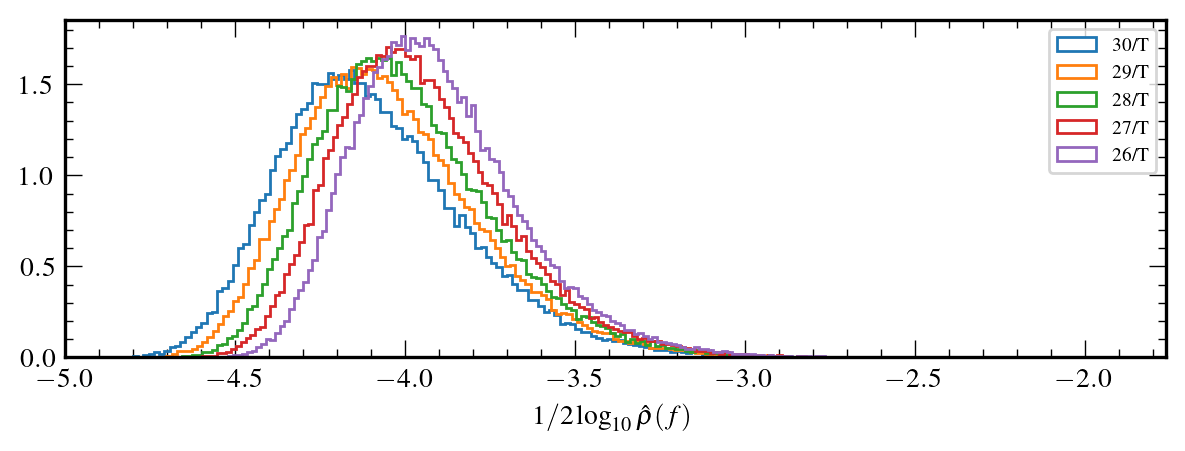

In [63]:
for ii in range(1, 6):
    plt.hist(0.5*np.log10(h2cf[:, -ii]/f_mid[-ii]**3), density=True, histtype='step', bins='fd',
             label=f'{31-ii}/T');
#plt.xlim(0., 0.004)
plt.xlabel(r'$1/2 \log_{10}\hat{\rho}(f)$')
plt.legend();

## testing skewness, kurtosis

In [147]:
from scripts.pop_synth import ideal_gwb, dN_dlog10Mdzdlogf, skewness, kurtosis

In [93]:
G = 4.517103 * 10**-48  # Mpc3 / Msun s2
c = 9.7156119 * 10**-15  # Mpc / s
fyr = 1/(365.24*86400)

# define models
# MODEL 1
model1 = dict(alpha=1, log10_M_star=np.log10(3.2*10**7), beta=3, z0=3, n0_dot=2e-2)
model2 = dict(alpha=0.5, log10_M_star=np.log10(7.5*10**7), beta=2.5, z0=2.4, n0_dot=9.5e-3)
model3 = dict(alpha=0., log10_M_star=np.log10(1.8*10**8), beta=2, z0=1.8, n0_dot=1.5e-3)
model4 = dict(alpha=-0.5, log10_M_star=np.log10(4.2*10**8), beta=1.5, z0=1.1, n0_dot=9e-5)
model5 = dict(alpha=-1, log10_M_star=9., beta=1, z0=0.5, n0_dot=2e-6)

models = [model1, model2, model3, model4, model5]

In [122]:
Tspan = 20 * 365.24 * 86400
fbins = (np.arange(1, 32) - 0.5)/Tspan

z_bins = np.linspace(0, 5, 101)
log10_M_bins = np.linspace(6, 11, 1001)

f_mid = 0.5 * (fbins[1:] + fbins[:-1])
log10_M_mid = 0.5 * (log10_M_bins[1:] + log10_M_bins[:-1])
z_mid = 0.5 * (z_bins[1:] + z_bins[:-1])

dlogf = (np.log(fbins[1:]) - np.log(fbins[:-1]))

In [123]:
moments = np.zeros((5, 4, 30))

for ii in range(5):
    N = dN_dlog10Mdzdlogf(fbins, 10**log10_M_bins, z_bins, models[ii],
                          mass_limit=False)
    moments[ii] = ideal_gwb(N, f_mid, log10_M_mid, z_mid, dlogf,
                               models[ii])

In [124]:
skew, kurt = skewness(moments[1]), kurtosis(moments[1])

In [125]:
skew

array([3.97890482e-32, 2.15629739e-31, 5.62108873e-31, 1.10442756e-30,
       1.86244756e-30, 2.85289577e-30, 4.09037566e-30, 5.58793731e-30,
       7.35743535e-30, 9.40977051e-30, 1.17550613e-29, 1.44027711e-29,
       1.73618049e-29, 2.06405850e-29, 2.42471117e-29, 2.81890126e-29,
       3.24735831e-29, 3.71078201e-29, 4.20984516e-29, 4.74519602e-29,
       5.31746048e-29, 5.92724392e-29, 6.57513275e-29, 7.26169588e-29,
       7.98748595e-29, 8.75304046e-29, 9.55888273e-29, 1.04055229e-28,
       1.12934585e-28, 1.22231755e-28])

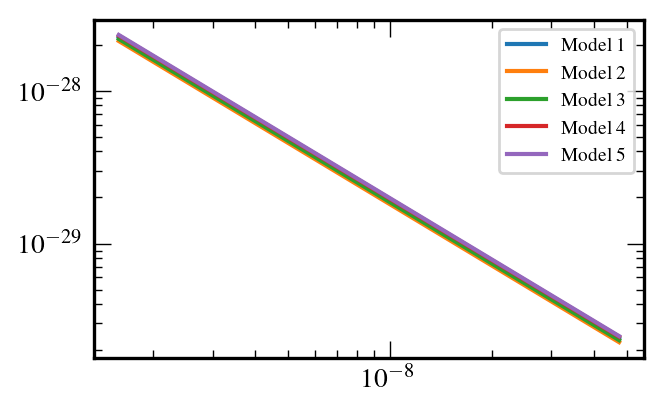

In [126]:
# mean
for ii in range(5):
    plt.loglog(f_mid, moments[ii, 0], label=f'Model {ii+1}')
plt.legend()

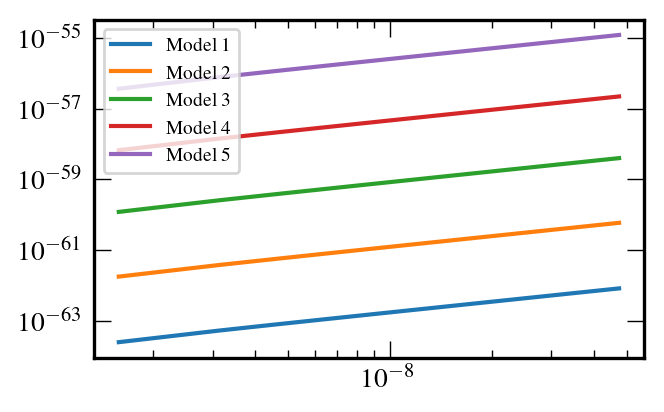

In [127]:
# variance
for ii in range(5):
    plt.loglog(f_mid, moments[ii, 1], label=f'Model {ii+1}')
plt.legend()

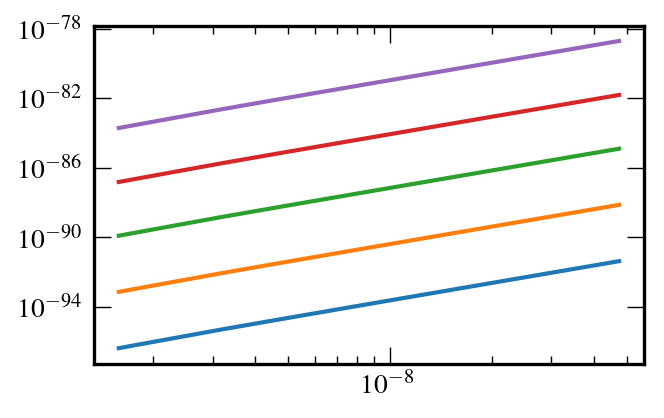

In [128]:
# 3rd non-central moment
for ii in range(5):
    plt.loglog(f_mid, moments[ii, 2], label=f'Model {ii+1}')
    #x3 = 0*moments[ii, 1]*moments[ii, 0] + moments[ii, 2]
    #plt.loglog(f_mid, x3, label=f'Model {ii+1}')
#plt.legend()

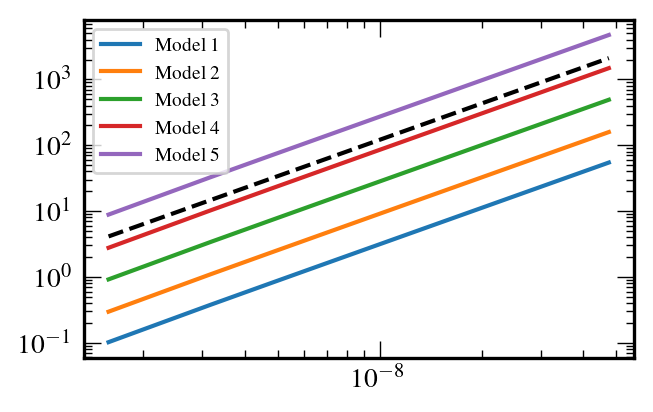

In [131]:
# skewness
for ii in range(5):
    skew = skewness(moments[ii])
    plt.loglog(f_mid, skew, label=f'Model {ii+1}')
plt.legend()

#plt.plot(f_mid, 100 * (f_mid/fyr)**(-11/6), c='k', ls='--')
plt.plot(f_mid, 1000 * (f_mid/fyr)**(11/6), c='k', ls='--')

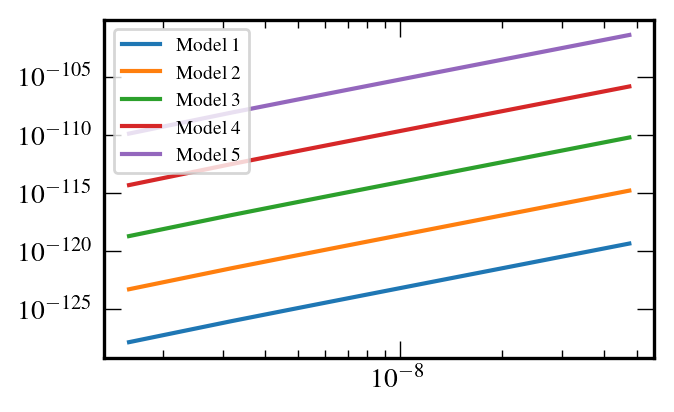

In [106]:
# 4th non-central moment
for ii in range(5):
    plt.loglog(f_mid, moments[ii, 3], label=f'Model {ii+1}')
plt.legend()

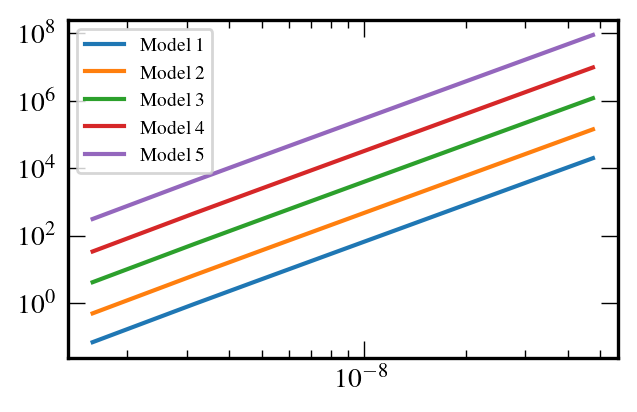

In [133]:
for ii in range(5):
    kurt = kurtosis(moments[ii])
    plt.loglog(f_mid, kurt, label=f'Model {ii+1}')
plt.legend()

#plt.plot(f_mid, 100 * (f_mid/fyr)**(-11/3), c='k', ls='--')
#plt.plot(f_mid, 1000 * (f_mid/fyr)**(11/3), c='k', ls='--')

## compare to simulations

In [134]:
# load some precomputed backgrounds!
h2cf = np.load('./data/hc2f_10k_model1.npy')[:99999]
for ii in range(2, 6):
    h2cf = np.dstack((h2cf, np.load(f'./data/hc2f_10k_model{ii}.npy')[:99999]))

In [140]:
Tspan = 20 * 365.24 * 86400
freqs = np.arange(1, 31) / Tspan

In [155]:
h2cf.shape

(99999, 30, 5)

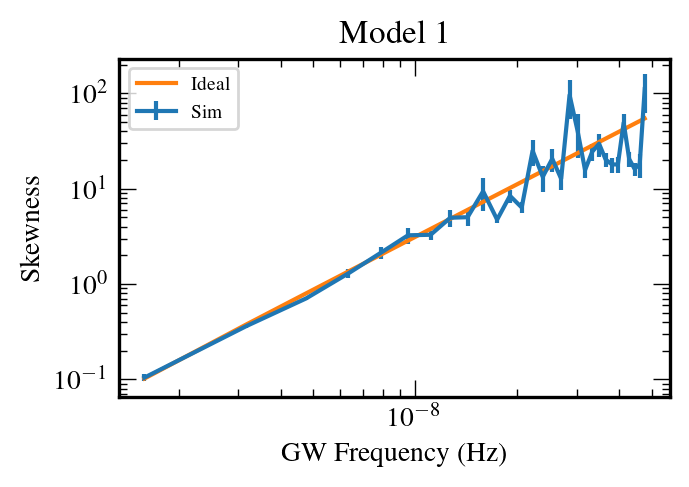

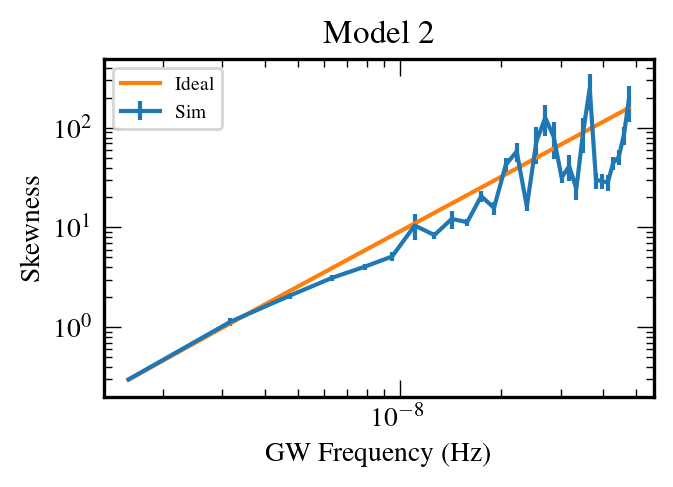

In [157]:
sim_skew = skew(h2cf, axis=0)
for ii in range(5):
    #plt.loglog(freqs, sim_skew[:, ii], label=f'Sim')
    
    # bootstrap
    boot_skew = np.zeros((h2cf.shape[0], 30))
    for jj in range(h2cf.shape[0]):
        idxs = np.random.choice(h2cf.shape[0], h2cf.shape[0], replace=True)
        boot_skew[jj] = skew(h2cf[idxs, :, ii], axis=0)
    err_skew = np.std(boot_skew, axis=0)

    plt.errorbar(freqs, sim_skew[:, ii], yerr=err_skew, label=f'Sim')

    ideal_skew = skewness(moments[ii])
    plt.plot(freqs, ideal_skew, label=f'Ideal')

    plt.legend()
    plt.title(f'Model {ii+1}')
    plt.xlabel('GW Frequency (Hz)')
    plt.ylabel('Skewness')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()


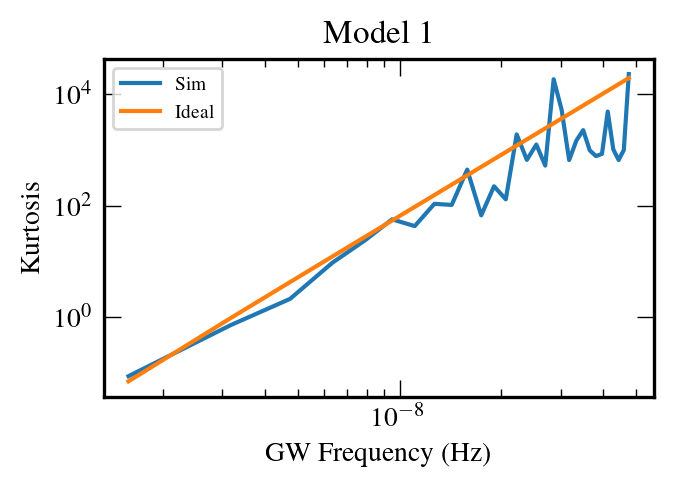

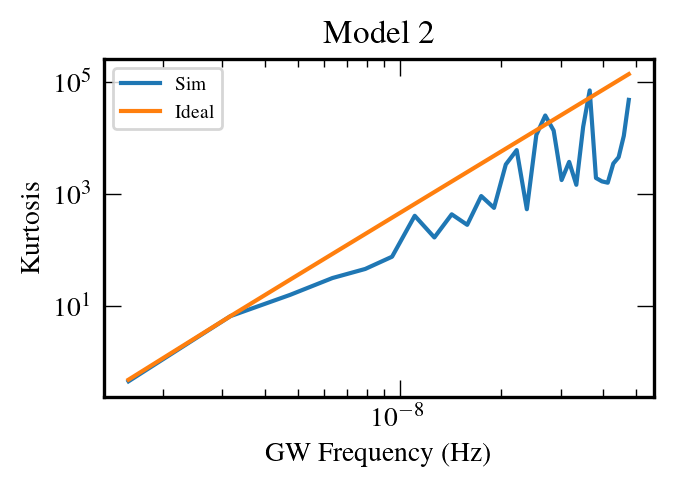

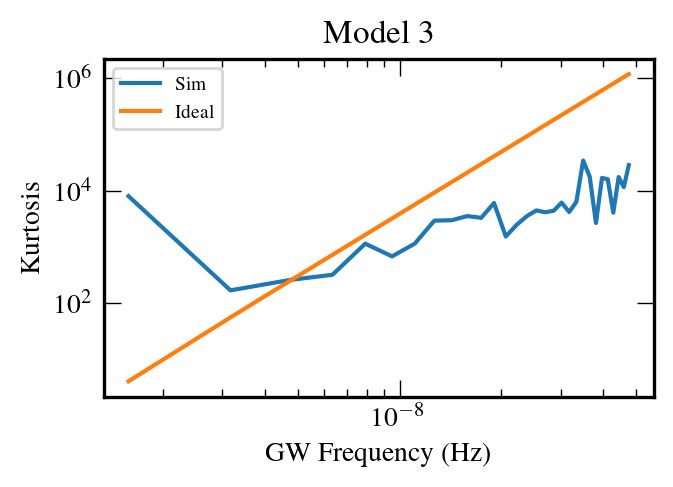

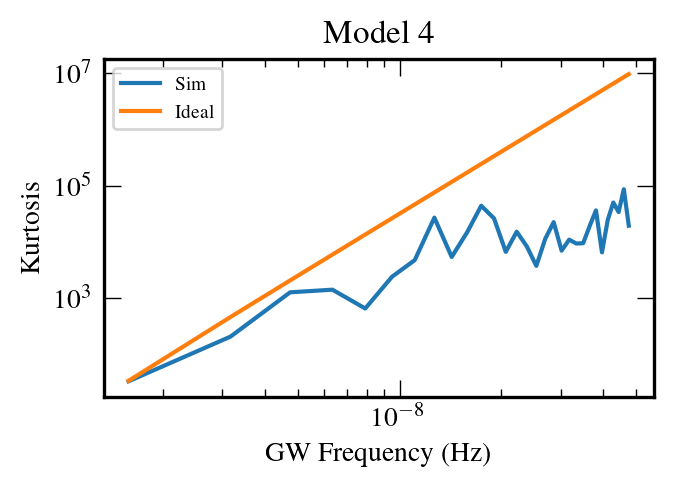

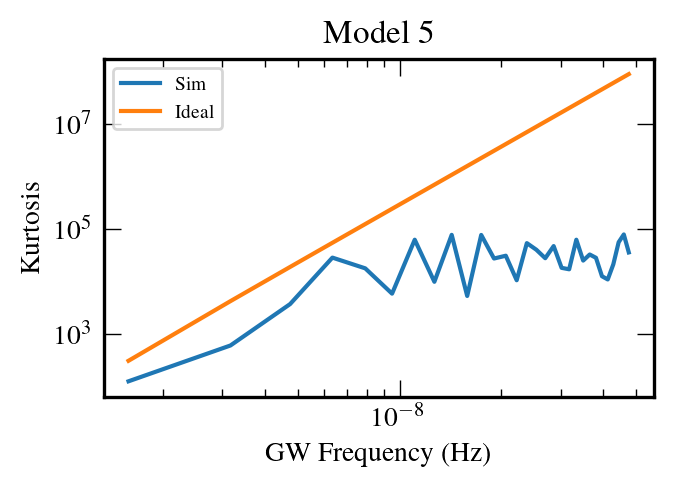

In [152]:
sim_kurt = kurt_sp(h2cf, axis=0)
for ii in range(5):
    plt.loglog(freqs, sim_kurt[:, ii], label=f'Sim')

    ideal_kurt = kurtosis(moments[ii])
    plt.loglog(freqs, ideal_kurt, label=f'Ideal')

    plt.legend()
    plt.title(f'Model {ii+1}')
    plt.xlabel('GW Frequency (Hz)')
    plt.ylabel('Kurtosis')
    plt.show()
